<a href="https://colab.research.google.com/github/ucbtns/deep_active_inference_IWAI23/blob/main/deep_active_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to define a deep active inference agent?

In [3]:
# base packages
import os, time, numpy as np, matplotlib.pyplot as plt, scipy
from sys import argv
from distutils.dir_util import copy_tree
%tensorflow_version 2.x
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

!pip install dill
!pip install opencv-python
!pip install tqdm
!pip install sk-video
!pip install torch==1.5.0
!pip install gym==0.17.2
!pip install higher==0.2
!pip install kornia==0.3.0
!pip install procgen
!pip install torchvision
!pip install scikit-image
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

!pip install gym
!pip install pyglet==1.5.15
import dill
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive/')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
ERROR: Could not find a version that satisfies the requirement torch==1.5.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.5.0
  Using cached pyglet-1.5.0-py2.py3-none-any.whl (1.0 MB)
  Attempting uninstall: pyglet
    Found existing installation: pyglet 1.5.15
    Uninstalling pyglet-1.5.15:
      Successfully uninstalled pyglet-1.5.15
  Using cached kornia-0.3.0-py2.py3-none-any.whl (158 kB)
INFO: pip is looking at multiple versions of kornia to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement torch==1.5.0 (from kornia) (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.5.0
  Using cached pyglet-1.5.15-py3-none-any.whl (1.1 MB)
  Attempting uninstall: pyglet
    Found exi

In [4]:
try:
  os.mkdir('/content/drive/MyDrive/deep_active_inference')
except: print("Directory already exists")

os.chdir('/content/drive/MyDrive/deep_active_inference')

Directory already exists


In [5]:
# Git repo:
! [ ! -d 'deep_active_inference_IWAI23' ] && git clone --single-branch --branch main https://github.com/ucbtns/deep_active_inference_IWAI23
os.chdir('/content/drive/MyDrive/deep_active_inference/deep_active_inference_IWAI23')

Set-up

In [6]:
# Get dsprites data
# This defines a simple object-sorting task based on [DeepMind's dSprites dataset](https://github.com/deepmind/dsprites-dataset/).
! wget -nc https://github.com/deepmind/dsprites-dataset/raw/master/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz

File ‘dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz’ already there; not retrieving.



In [7]:
# Check you have the right folder + data downloaded
os.listdir()

['.git',
 '.DS_Store',
 'LICENSE',
 'README.md',
 'graphs',
 'src',
 'test_demo.py',
 'dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz',
 'figs_final_model_0.01_30_1.0_50_10_5',
 'train.py']

In [8]:
# Import custom libraries
from src.game_environment import Game
import src.util as u
import src.tfloss as loss
from src.tfmodel import ActiveInferenceModel
from src.tfutils import *
from graphs.reconstructions_plot import reconstructions_plot
from graphs.generate_traversals import generate_traversals
from graphs.stats_plot import stats_plot

## Defining the generative model networks

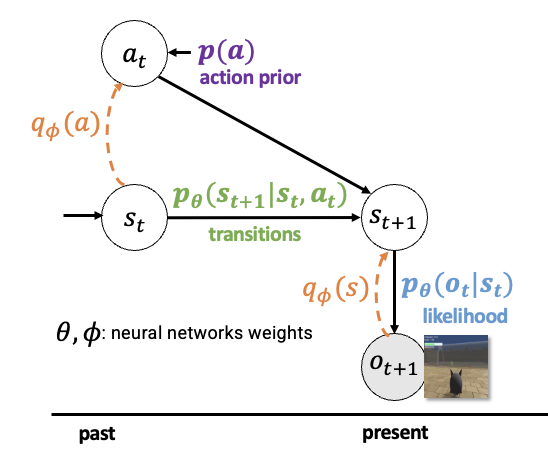

### Likelihood $p_{\theta}(o_t|s_t)$ and variational distribution $q_{\phi}(s_t)$:

---



In [9]:
class ModelDown(tf.keras.Model):
    def __init__(self, s_dim, pi_dim, tf_precision, precision, colour_channels, resolution):
        super(ModelDown, self).__init__()

        self.tf_precision = tf_precision
        self.precision = precision
        tf.keras.backend.set_floatx(self.precision)

        self.s_dim = s_dim
        self.pi_dim = pi_dim
        self.colour_channels = colour_channels
        self.resolution = resolution
        if self.resolution == 64:
            last_strides = 2
        elif self.resolution == 32:
            last_strides = 1
        else:
            exit('Unknown resolution..')

        self.qs_net = tf.keras.Sequential([
              tf.keras.layers.InputLayer(input_shape=(self.resolution, self.resolution, self.colour_channels)),
              tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu', kernel_initializer='he_uniform'),
              tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu', kernel_initializer='he_uniform'),
              tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu', kernel_initializer='he_uniform'),
              tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu', kernel_initializer='he_uniform'),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(256, activation=tf.nn.relu, kernel_initializer='he_uniform'),
              tf.keras.layers.Dropout(0.5),
              tf.keras.layers.Dense(256, activation=tf.nn.relu, kernel_initializer='he_uniform'),
              tf.keras.layers.Dropout(0.5),
              tf.keras.layers.Dense(256, activation=tf.nn.relu, kernel_initializer='he_uniform'),
              tf.keras.layers.Dropout(0.5),
              tf.keras.layers.Dense(s_dim + s_dim),]) # No activation
        self.po_net = tf.keras.Sequential([
              tf.keras.layers.InputLayer(input_shape=(s_dim,)),
              tf.keras.layers.Dense(256, activation=tf.nn.relu, kernel_initializer='he_uniform'),
              tf.keras.layers.Dropout(0.5),
              tf.keras.layers.Dense(256, activation=tf.nn.relu, kernel_initializer='he_uniform'),
              tf.keras.layers.Dropout(0.5),
              tf.keras.layers.Dense(256, activation=tf.nn.relu, kernel_initializer='he_uniform'),
              tf.keras.layers.Dropout(0.5),
              tf.keras.layers.Dense(units=16*16*64, activation=tf.nn.relu, kernel_initializer='he_uniform'),
              tf.keras.layers.Dropout(0.5),
              tf.keras.layers.Reshape(target_shape=(16, 16, 64)),
              tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(1, 1), padding="SAME", activation='relu', kernel_initializer='he_uniform'),
              tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu', kernel_initializer='he_uniform'),
              tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(last_strides, last_strides), padding="SAME", activation='relu', kernel_initializer='he_uniform'),
              tf.keras.layers.Conv2DTranspose(filters=self.colour_channels, kernel_size=3, strides=(1, 1), padding="SAME", activation='sigmoid', kernel_initializer='he_uniform'),])

    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    @tf.function
    def encoder(self, o):
        grad_check = tf.debugging.check_numerics(self.qs_net(o), 'check_numerics caught bad temptemptemptemptemp3')
        mean_s, logvar_s = tf.split(self.qs_net(o), num_or_size_splits=2, axis=1)
        return mean_s, logvar_s

    @tf.function
    def decoder(self, s):
        po = self.po_net(s)
        return po

    @tf.function
    def encoder_with_sample(self, o):
        mean, logvar = self.encoder(o)
        s = self.reparameterize(mean, logvar)
        return s, mean, logvar



### Transition network $ p_{\theta}(s_{t+1}|s_{t},a_{t})$:

---

We use a feedforward network but this can easily be replaced with a RNN

In [10]:
class ModelMid(tf.keras.Model):
    def __init__(self, s_dim, pi_dim, tf_precision, precision):
        super(ModelMid, self).__init__()

        self.tf_precision = tf_precision
        self.precision = precision
        tf.keras.backend.set_floatx(self.precision)

        self.s_dim = s_dim
        self.pi_dim = pi_dim

        self.ps_net = tf.keras.Sequential([
              tf.keras.layers.InputLayer(input_shape=(pi_dim+s_dim,)),
              tf.keras.layers.Dense(units=512, activation=tf.nn.relu, kernel_initializer='he_uniform'),
              tf.keras.layers.Dropout(0.5),
              tf.keras.layers.Dense(units=512, activation=tf.nn.relu, kernel_initializer='he_uniform'),
              tf.keras.layers.Dropout(0.5),
              tf.keras.layers.Dense(units=512, activation=tf.nn.relu, kernel_initializer='he_uniform'),
              tf.keras.layers.Dropout(0.5),
              tf.keras.layers.Dense(s_dim + s_dim),]) # No activation

    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    @tf.function
    def transition(self, pi, s0):
        mean, logvar = tf.split(self.ps_net(tf.concat([pi,s0],1)), num_or_size_splits=2, axis=1)
        return mean, logvar

    @tf.function
    def transition_with_sample(self, pi, s0):
        ps1_mean, ps1_logvar = self.transition(pi, s0)
        ps1 = self.reparameterize(ps1_mean, ps1_logvar)
        return ps1, ps1_mean, ps1_logvar


### Habitual network $q_{\phi}(a)$:

---



In [11]:
class ModelTop(tf.keras.Model):
    def __init__(self, s_dim, pi_dim, tf_precision, precision):
        super(ModelTop, self).__init__()

        self.tf_precision = tf_precision
        self.precision = precision
        tf.keras.backend.set_floatx(self.precision)

        self.s_dim = s_dim
        self.pi_dim = pi_dim

        # For activation function we used ReLU.
        # For weight initialization we used He Uniform
        self.qpi_net = tf.keras.Sequential([
              tf.keras.layers.InputLayer(input_shape=(s_dim,)),
              tf.keras.layers.Dense(units=128, activation=tf.nn.relu, kernel_initializer='he_uniform'),
              tf.keras.layers.Dense(units=128, activation=tf.nn.relu, kernel_initializer='he_uniform'),
              tf.keras.layers.Dense(pi_dim),]) # No activation

    def encode_s(self, s0):
        logits_pi = self.qpi_net(s0)
        q_pi = tf.nn.softmax(logits_pi)
        log_q_pi = tf.math.log(q_pi+1e-20)
        return logits_pi, q_pi, log_q_pi

## Defining the generative model loss summands

### Likelihood loss

---
TERM A: $E_Q[log P(o_1|s_1)]$

TERM B: $ E_Q D_{kl}[Q(s_1)||P(s_1|s_0,p_i)]$

TERM C: $E_Q D_{kl}[Q(s_1)||N(0.0,1.0)]$



In [12]:
@tf.function
def compute_loss_down(model_down, o1, ps1_mean, ps1_logvar, omega, displacement = 0.00001):
    qs1_mean, qs1_logvar = model_down.encoder(o1)
    qs1 = model_down.reparameterize(qs1_mean, qs1_logvar)
    po1 = model_down.decoder(qs1)

    # A ---------
    bin_cross_entr = o1 * tf.math.log(displacement + po1) + (1 - o1) * tf.math.log(displacement + 1 - po1) # Binary Cross Entropy
    logpo1_s1 = tf.reduce_sum(bin_cross_entr, axis=[1,2,3])

    # C ---------
    kl_div_s_naive_anal = kl_div_loss_analytically_from_logvar_and_precision(qs1_mean, qs1_logvar, 0.0, 0.0, omega)
    kl_div_s_naive = tf.reduce_sum(kl_div_s_naive_anal, 1)

    # B ---------
    kl_div_s_anal = kl_div_loss_analytically_from_logvar_and_precision(qs1_mean, qs1_logvar, ps1_mean, ps1_logvar, omega)
    kl_div_s = tf.reduce_sum(kl_div_s_anal, 1)

    if model_down.gamma <= 0.05:
       F = - model_down.beta_o*logpo1_s1 + model_down.beta_s*kl_div_s_naive
    elif model_down.gamma >= 0.95:
       F = - model_down.beta_o*logpo1_s1 + model_down.beta_s*kl_div_s
    else:
       F = - model_down.beta_o*logpo1_s1 + model_down.beta_s*(model_down.gamma*kl_div_s + (1.0-model_down.gamma)*kl_div_s_naive)
    loss_terms = (-logpo1_s1, kl_div_s, kl_div_s_anal, kl_div_s_naive, kl_div_s_naive_anal)
    return F, loss_terms, po1, qs1


### Transition loss

---

TERM: $E_{Q} D_{kl}[Q(s_1)||P(s_1|s_0,p_i)]$

In [13]:
@tf.function
def compute_loss_mid(model_mid, s0, Ppi_sampled, qs1_mean, qs1_logvar, omega):
    ps1, ps1_mean, ps1_logvar = model_mid.transition_with_sample(Ppi_sampled, s0)
    # ----------------------------------------------------------------------
    kl_div_s_anal = kl_div_loss_analytically_from_logvar_and_precision(qs1_mean, qs1_logvar, ps1_mean, ps1_logvar, omega)
    kl_div_s = tf.reduce_sum(kl_div_s_anal, 1)

    F_mid = kl_div_s
    loss_terms = (kl_div_s, kl_div_s_anal)
    return F_mid, loss_terms, ps1, ps1_mean, ps1_logvar

To optimise the model please see tfloss.py for individual gradient optimisation functions.

## Policy learning using uncertainty minimisation

### Habitual loss

---

TERM: $E_Q D_{kl}[Q(p_i|s_0)||P(p_i)]$, where $P(p_i) = U(0,5)$ is a Categorical K-L divergence

Here, $p_i$ is one step

In [14]:
@tf.function
def compute_loss_top(model_top, s, log_Ppi):
    _, Qpi, log_Qpi = model_top.encode_s(s)

    kl_div_pi_anal = Qpi*(log_Qpi - log_Ppi)
    kl_div_pi = tf.reduce_sum(kl_div_pi_anal, 1)

    F_top = kl_div_pi
    return F_top, kl_div_pi, kl_div_pi_anal, Qpi

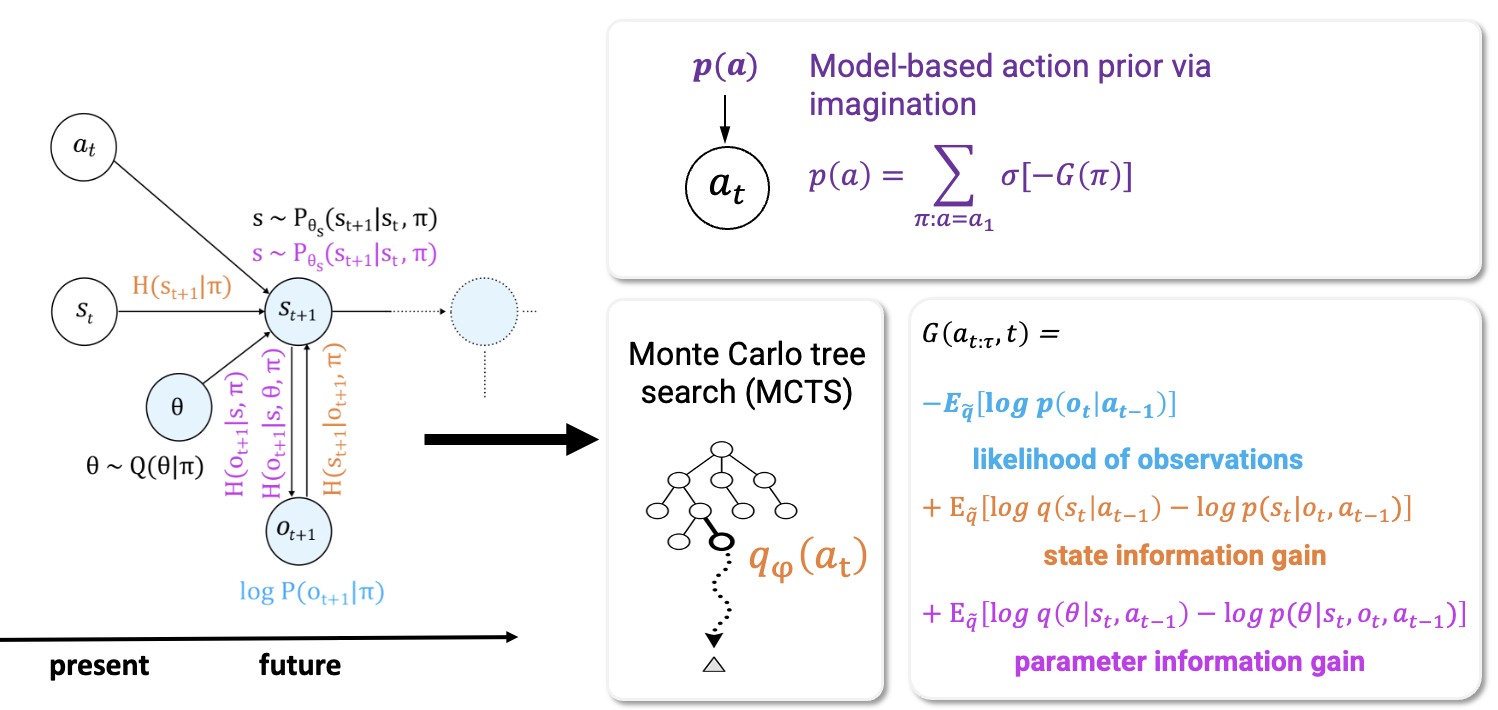

### MPC + MCTS using the defined generative model model

---


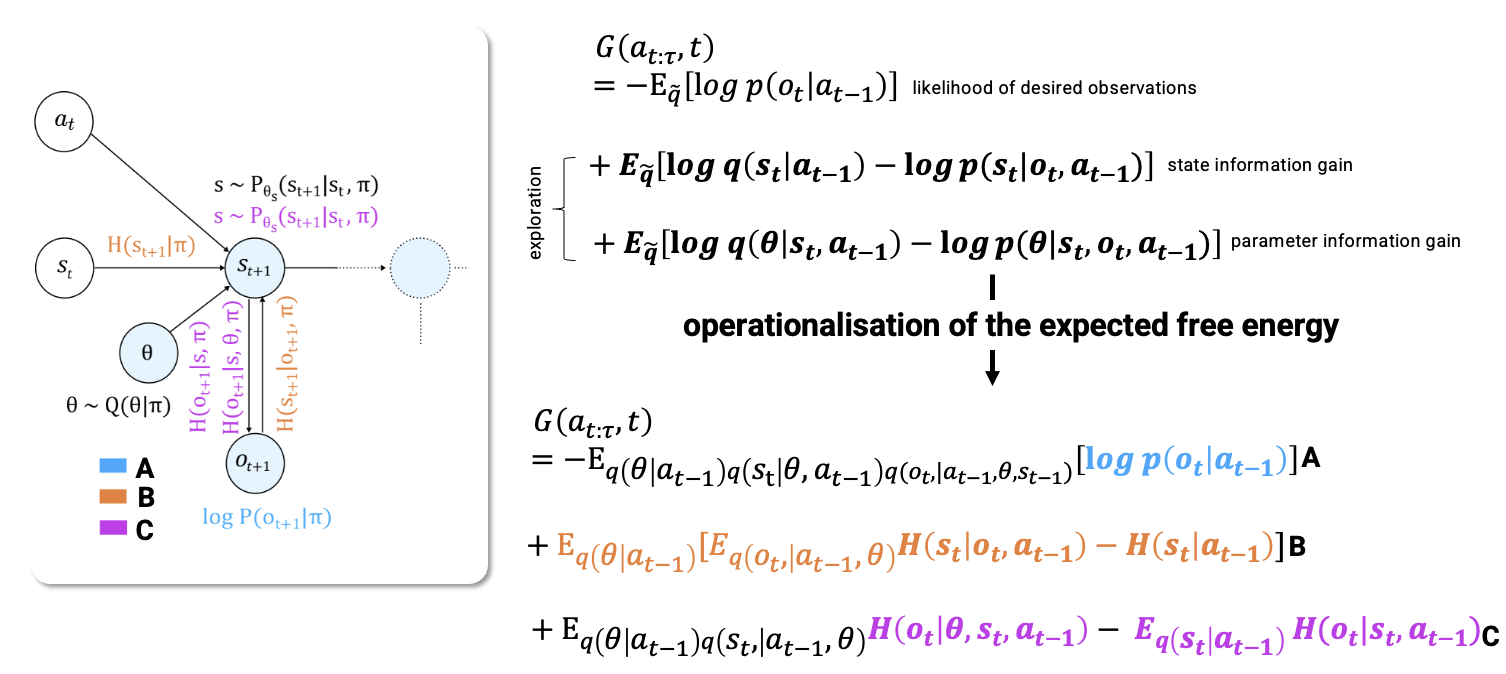

In [15]:
class DEMOActiveInferenceModel:
    # This is missing load + save functions
    def __init__(self, s_dim, pi_dim, gamma, beta_s, beta_o, colour_channels=1, resolution=64):

        self.tf_precision = tf.float32
        self.precision = 'float32'

        self.s_dim = s_dim
        self.pi_dim = pi_dim
        tf.keras.backend.set_floatx(self.precision)

        if self.pi_dim > 0: # only if there are actions
            self.model_top = ModelTop(s_dim, pi_dim, self.tf_precision, self.precision)
            self.model_mid = ModelMid(s_dim, pi_dim, self.tf_precision, self.precision)
        self.model_down = ModelDown(s_dim, pi_dim, self.tf_precision, self.precision, colour_channels, resolution)

        # These are hyperparameters used
        self.model_down.beta_s = tf.Variable(beta_s, trainable=False, name="beta_s")
        self.model_down.gamma = tf.Variable(gamma, trainable=False, name="gamma")
        self.model_down.beta_o = tf.Variable(beta_o, trainable=False, name="beta_o")

        # One hot encoding of the policy space
        self.pi_one_hot = tf.Variable([[1.0,0.0,0.0,0.0],
                                       [0.0,1.0,0.0,0.0],
                                       [0.0,0.0,1.0,0.0],
                                       [0.0,0.0,0.0,1.0]], trainable=False, dtype=self.tf_precision)
        self.pi_one_hot_3 = tf.Variable([[1.0,0.0,0.0],
                                         [0.0,1.0,0.0],
                                         [0.0,0.0,1.0]], trainable=False, dtype=self.tf_precision)

    def check_reward(self, o):
        if self.model_down.resolution == 64:
            return tf.reduce_mean(calc_reward(o),axis=[1,2,3]) * 10.0
        elif self.model_down.resolution == 32:
            return tf.reduce_sum(calc_reward_animalai(o), axis=[1,2,3])


    @tf.function
    def imagine_future_from_o(self, o0, pi):
        s0, _, _ = self.model_down.encoder_with_sample(o0)
        ps1, _, _ = self.model_mid.transition_with_sample(pi, s0)
        po1 = self.model_down.decoder(ps1)
        return po1

    @tf.function
    def habitual_net(self, o):
        # Behaviour of the agent from the $q(a)$:
        qs_mean, _ = self.model_down.encoder(o)
        _, Qpi, _ = self.model_top.encode_s(qs_mean)
        return Qpi

    @tf.function
    def calculate_G_repeated(self, o, pi, steps=1, calc_mean=False, samples=10):
        """
        We simultaneously calculate G for the four policies of repeating each
        one of the four actions continuously.
        """

        # Calculate current s_t
        qs0_mean, qs0_logvar = self.model_down.encoder(o)
        qs0 = self.model_down.reparameterize(qs0_mean, qs0_logvar)

        sum_terms = [tf.zeros([o.shape[0]], self.tf_precision), tf.zeros([o.shape[0]], self.tf_precision), tf.zeros([o.shape[0]], self.tf_precision)]
        sum_G = tf.zeros([o.shape[0]], self.tf_precision)

        # Predict s_t+1 for various policies
        if calc_mean: s0_temp = qs0_mean
        else: s0_temp = qs0

        for t in range(steps):
            G, terms, s1, ps1_mean, po1 = self.calculate_G(s0_temp, pi, samples=samples)

            sum_terms[0] += terms[0]
            sum_terms[1] += terms[1]
            sum_terms[2] += terms[2]
            sum_G += G

            if calc_mean:
                s0_temp = ps1_mean
            else:
                s0_temp = s1

        return sum_G, sum_terms, po1

    @tf.function
    def calculate_G_4_repeated(self, o, steps=1, calc_mean=False, samples=10):
        """
        We simultaneously calculate G for the four policies of repeating each
        one of the four actions continuously with the option to use G mean.
        """
        # Calculate current s_t
        qs0_mean, qs0_logvar = self.model_down.encoder(o)
        qs0 = self.model_down.reparameterize(qs0_mean, qs0_logvar)

        sum_terms = [tf.zeros([4], self.tf_precision), tf.zeros([4], self.tf_precision), tf.zeros([4], self.tf_precision)]
        sum_G = tf.zeros([4], self.tf_precision)

        # Predict s_t+1 for various policies
        if calc_mean: s0_temp = qs0_mean
        else: s0_temp = qs0

        for t in range(steps):
            if calc_mean:
                G, terms, ps1_mean, po1 = self.calculate_G_mean(s0_temp, self.pi_one_hot)
            else:
                G, terms, s1, ps1_mean, po1 = self.calculate_G(s0_temp, self.pi_one_hot, samples=samples)

            sum_terms[0] += terms[0]
            sum_terms[1] += terms[1]
            sum_terms[2] += terms[2]
            sum_G += G

            if calc_mean:
                s0_temp = ps1_mean
            else:
                s0_temp = s1

        return sum_G, sum_terms, po1

    @tf.function
    def calculate_G(self, s0, pi0, samples=10):

        term0 = tf.zeros([s0.shape[0]], self.tf_precision)
        term1 = tf.zeros([s0.shape[0]], self.tf_precision)

        for _ in range(samples):
            ps1, ps1_mean, ps1_logvar = self.model_mid.transition_with_sample(pi0, s0)
            po1 = self.model_down.decoder(ps1)
            qs1, _, qs1_logvar = self.model_down.encoder_with_sample(po1)

            # E [ log P(o|pi) ]
            logpo1 = self.check_reward(po1)
            term0 += logpo1

            # E [ log Q(s|pi) - log Q(s|o,pi) ]
            term1 += - tf.reduce_sum(entropy_normal_from_logvar(ps1_logvar) + entropy_normal_from_logvar(qs1_logvar), axis=1)
        term0 /= float(samples)
        term1 /= float(samples)

        term2_1 = tf.zeros(s0.shape[0], self.tf_precision)
        term2_2 = tf.zeros(s0.shape[0], self.tf_precision)
        for _ in range(samples):
            # Term 2.1: Sampling different thetas, i.e. sampling different ps_mean/logvar with dropout!
            po1_temp1 = self.model_down.decoder(self.model_mid.transition_with_sample(pi0, s0)[0])
            term2_1 += tf.reduce_sum(entropy_bernoulli(po1_temp1),axis=[1,2,3])

            # Term 2.2: Sampling different s with the same theta, i.e. just the reparametrization trick!
            po1_temp2 = self.model_down.decoder(self.model_down.reparameterize(ps1_mean, ps1_logvar))
            term2_2 += tf.reduce_sum(entropy_bernoulli(po1_temp2),axis=[1,2,3])
        term2_1 /= float(samples)
        term2_2 /= float(samples)

        # E [ log [ H(o|s,th,pi) ] - E [ H(o|s,pi) ]
        term2 = term2_1 - term2_2

        G = - term0 + term1 + term2

        return G, [term0, term1, term2], ps1, ps1_mean, po1

    @tf.function
    def calculate_G_mean(self, s0, pi0):

        _, ps1_mean, ps1_logvar = self.model_mid.transition_with_sample(pi0, s0)
        po1 = self.model_down.decoder(ps1_mean)
        _, qs1_mean, qs1_logvar = self.model_down.encoder_with_sample(po1)

        # E [ log P(o|pi) ]
        logpo1 = self.check_reward(po1)
        term0 = logpo1

        # E [ log Q(s|pi) - log Q(s|o,pi) ]
        term1 = - tf.reduce_sum(entropy_normal_from_logvar(ps1_logvar) + entropy_normal_from_logvar(qs1_logvar), axis=1)

        # Term 2.1: Sampling different thetas, i.e. sampling different ps_mean/logvar with dropout!
        po1_temp1 = self.model_down.decoder(self.model_mid.transition_with_sample(pi0, s0)[1])
        term2_1 = tf.reduce_sum(entropy_bernoulli(po1_temp1),axis=[1,2,3])

        # Term 2.2: Sampling different s with the same theta, i.e. just the reparametrization trick!
        po1_temp2 = self.model_down.decoder(self.model_down.reparameterize(ps1_mean, ps1_logvar))
        term2_2 = tf.reduce_sum(entropy_bernoulli(po1_temp2),axis=[1,2,3])

        # E [ log [ H(o|s,th,pi) ] - E [ H(o|s,pi) ]
        term2 = term2_1 - term2_2

        G = - term0 + term1 + term2

        return G, [term0, term1, term2], ps1_mean, po1

    @tf.function
    def calculate_G_given_trajectory(self, s0_traj, ps1_traj, ps1_mean_traj, ps1_logvar_traj, pi0_traj):
        # NOTE: len(s0_traj) = len(s1_traj) = len(pi0_traj)

        po1 = self.model_down.decoder(ps1_traj)
        qs1, _, qs1_logvar = self.model_down.encoder_with_sample(po1)

        # E [ log P(o|pi) ]
        term0 = self.check_reward(po1)

        # E [ log Q(s|pi) - log Q(s|o,pi) ]
        term1 = - tf.reduce_sum(entropy_normal_from_logvar(ps1_logvar_traj) + entropy_normal_from_logvar(qs1_logvar), axis=1)

        #  Term 2.1: Sampling different thetas, i.e. sampling different ps_mean/logvar with dropout!
        po1_temp1 = self.model_down.decoder(self.model_mid.transition_with_sample(pi0_traj, s0_traj)[0])
        term2_1 = tf.reduce_sum(entropy_bernoulli(po1_temp1),axis=[1,2,3])

        # Term 2.2: Sampling different s with the same theta, i.e. just the reparametrization trick!
        po1_temp2 = self.model_down.decoder(self.model_down.reparameterize(ps1_mean_traj, ps1_logvar_traj))
        term2_2 = tf.reduce_sum(entropy_bernoulli(po1_temp2),axis=[1,2,3])

        # E [ log [ H(o|s,th,pi) ] - E [ H(o|s,pi) ]
        term2 = term2_1 - term2_2

        return - term0 + term1 + term2


    def mcts_step_simulate(self, starting_s, depth, use_means=False):
        s0 = np.zeros((depth, self.s_dim), self.precision)
        ps1 = np.zeros((depth, self.s_dim), self.precision)
        ps1_mean = np.zeros((depth, self.s_dim), self.precision)
        ps1_logvar = np.zeros((depth, self.s_dim), self.precision)
        pi0 = np.zeros((depth, self.pi_dim), self.precision)

        s0[0] = starting_s
        try:
            Qpi_t_to_return = self.model_top.encode_s(s0[0].reshape(1,-1))[1].numpy()[0]
            pi0[0, np.random.choice(self.pi_dim, p=Qpi_t_to_return)] = 1.0
        except:
            pi0[0, 0] = 1.0
            Qpi_t_to_return = pi0[0]
        ps1_new, ps1_mean_new, ps1_logvar_new = self.model_mid.transition_with_sample(pi0[0].reshape(1,-1), s0[0].reshape(1,-1))
        ps1[0] = ps1_new[0].numpy()
        ps1_mean[0] = ps1_mean_new[0].numpy()
        ps1_logvar[0] = ps1_logvar_new[0].numpy()
        if 1 < depth:
            if use_means:
                s0[1] = ps1_mean_new[0].numpy()
            else:
                s0[1] = ps1_new[0].numpy()
        for t in range(1, depth):
            try:
                pi0[t, np.random.choice(self.pi_dim, p=self.model_top.encode_s(s0[t].reshape(1,-1))[1].numpy()[0])] = 1.0
            except:
                pi0[t, 0] = 1.0
            ps1_new, ps1_mean_new, ps1_logvar_new = self.model_mid.transition_with_sample(pi0[t].reshape(1,-1), s0[t].reshape(1,-1))
            ps1[t] = ps1_new[0].numpy()
            ps1_mean[t] = ps1_mean_new[0].numpy()
            ps1_logvar[t] = ps1_logvar_new[0].numpy()
            if t+1 < depth:
                if use_means:
                    s0[t+1] = ps1_mean_new[0].numpy()
                else:
                    s0[t+1] = ps1_new[0].numpy()

        G = tf.reduce_mean(self.calculate_G_given_trajectory(s0, ps1, ps1_mean, ps1_logvar, pi0)).numpy()
        return G, pi0, Qpi_t_to_return

### Active Inference MCTS formulation

---



In [16]:
def active_inference_mcts(model, frame, params, o_shape=(64,64,1)):
    states_explored = 0
    all_paths = [] # For debugging.
    all_paths_G = [] # For debugging.
    if frame == []:
        return [0], 0, states_explored, all_paths, all_paths_G

    # Calculate current s_t
    qs0_mean, qs0_logvar = model.model_down.encoder(frame.reshape(1,o_shape[0],o_shape[1],o_shape[2]))

    # Important to be the mean here as we repeat it model.pi_dim times!
    root = Node(s=qs0_mean[0], model=model, C=params.C, pi_dim=model.pi_dim, using_prior_for_exploration=params.using_prior_for_exploration)

    # Habit.
    root.Qpi = model.model_top.encode_s(qs0_mean)[1].numpy()[0]

    if params.use_habit:
        if calc_threshold(root.Qpi, axis=0) > params.threshold:
            if params.verbose: print('Decision in phase A Qpi:',root.Qpi, calc_threshold(root.Qpi,axis=0))
            MCTS_choices = root.Qpi
            return [np.random.choice(model.pi_dim, p=root.Qpi)], 0, states_explored, all_paths, all_paths_G

    root.expand(use_means=params.use_means)

    for repeat in range(params.repeats):

        if calc_threshold(normalization(root.N),axis=0) > params.threshold:
            MCTS_choices = normalization(root.N)
            if params.verbose: print('Decision in phase B',np.round(root.probs_for_selection(),2), np.round(MCTS_choices,2),
                                   calc_threshold(MCTS_choices,axis=0), 'N:', root.N)
            final_path = root.action_selection(deterministic=True)
            return final_path, repeat, states_explored, all_paths, all_paths_G

        path, actions_path = root.select(deterministic=True) # Path[-1] is a leaf node!
        path[-1].expand(use_means=params.use_means)
        all_av_G = np.zeros(params.simulation_repeats)
        for sim_repeat in range(params.simulation_repeats):
            states_explored += params.simulation_depth
            all_av_G[sim_repeat], pi0, path[-1].Qpi = model.mcts_step_simulate(path[-1].s[0], params.simulation_depth, use_means=False)
        path[-1].backpropagate([root] + path[:-1], all_av_G.mean())
        all_paths.append(actions_path)
        all_paths_G.append(all_av_G.mean())

    final_path = root.action_selection(deterministic=True)
    if params.verbose: print('Decision in phase C', root.N, len(all_paths), np.round(root.Q()-np.min(root.Q()),2), np.round(root.C * root.Qpi * np.sqrt(root.N.sum())/(1.0+root.N),2), 'Qpi:', np.round(root.Qpi,2))
    return final_path, params.repeats, states_explored, all_paths, all_paths_G


### MCTS Algorithm

---



In [17]:
NODE_ID = 0
class Node:
    def __init__(self, s, model, C, pi_dim=4, verbose=False, using_prior_for_exploration=False):
        global NODE_ID

        # The latent state that corresponds to this node!
        self.pi_dim = pi_dim
        self.s = np.stack((s,)*self.pi_dim, axis=0) # NOTE: It's saved self.pi_dim times to simplify calculations.
        self.model = model
        self.verbose = verbose
        self.using_prior_for_exploration = using_prior_for_exploration
        self.visited = False # For visulization
        self.NODE_ID = NODE_ID
        NODE_ID += 1

        if self.verbose: print('NEW NODE:', np.shape(self.s),self.NODE_ID)

        self.W = np.zeros(self.pi_dim) # The total value of G so far in the next state given an edge..
        self.N = np.zeros(self.pi_dim) # The total number of times an action was explored from here..
        self.Qpi = np.zeros(self.pi_dim) # Prior probability distribution for actions..
        self.children_nodes = [None for _ in range(self.pi_dim)]
        self.C = C #100.0 # 1.0 # A constant in AlphaGo Zero... [it was 1.0 in that paper..]
        # This takes the index of the child node that is currently under investigation.
        # It's important for the back-propagation of G, to remember which action was taken!
        self.in_progress = -1

    def Q(self):
        return self.W/self.N

    def probs_for_selection(self):
        # Initially normalize Q() to make it a distribution.
        Qnormed = self.Q()
        Qnormed -= Qnormed.min()
        Qnormed = Qnormed/Qnormed.sum()
        if self.using_prior_for_exploration:
            return Qnormed + self.C * self.Qpi * 1.0/(self.N)
        else:
            return Qnormed + self.C * 1.0/(self.N)

    def select(self, deterministic=True):
        path = []
        actions_path = []
        if deterministic: self.in_progress = np.argmax(self.probs_for_selection())
        else: self.in_progress = np.random.choice(self.pi_dim, p=self.probs_for_selection())
        actions_path.append(self.in_progress)
        path.append(self.children_nodes[self.in_progress])
        while None not in path[-1].children_nodes: # If not leaf!
            if deterministic: path[-1].in_progress = np.argmax(path[-1].probs_for_selection())
            else: path[-1].in_progress = np.random.choice(self.pi_dim, p=path[-1].probs_for_selection())
            actions_path.append(path[-1].in_progress)
            path.append(path[-1].children_nodes[path[-1].in_progress])
        if self.verbose: print('Select:', [p.NODE_ID for p in path], actions_path)
        return path, actions_path

    def expand(self, use_means=False, samples=1):
        """
        Note: It works if 'self' is a leaf.
        Expanding assigning a state and an initial expected free energy in all
        children nodes of the current leaf!
        """
        if self.pi_dim == 4:
            PI_HOT = self.model.pi_one_hot
        elif self.pi_dim == 3:
            PI_HOT = self.model.pi_one_hot_3
        else:
            exit('Errr: '+str(self.pi_dim))

        if use_means:
            G, _, ps_next_mean, _ = self.model.calculate_G_mean(self.s, PI_HOT)
            ps_next = ps_next_mean
        else:
            G, _, ps_next, _, _ = self.model.calculate_G(self.s, PI_HOT, samples=samples)
        self.W -= G.numpy() # Note: Negative expected free energy to be used as a Q value in RL applications.
        self.N += 1.0
        for i in range(self.pi_dim):
            self.children_nodes[i] = Node(s=ps_next[i], model=self.model, C=self.C, pi_dim=self.pi_dim, using_prior_for_exploration=self.using_prior_for_exploration)
        if self.verbose: print('Expand:',G.numpy(), self.W, self.N)

    #@tf.function
    def backpropagate(self, path, G):
        if self.verbose: print('Back-propagate:', [p.NODE_ID for p in path], G.numpy())
        for i in range(len(path)):
            if path[i].in_progress < 0:
                exit('Back-propagation error: '+str(path)+' '+str(i))
            path[i].W[path[i].in_progress] -= G
            path[i].N[path[i].in_progress] += 1
            path[i].in_progress = -2 # just to remember it's been examined..
            if self.verbose: print('Propagating to node', path[i].NODE_ID, 'with N:', path[i].N)

    #@tf.function
    def action_selection(self, deterministic=True):
        path = []
        if deterministic: path.append(np.argmax(self.N))
        else: path.append(np.random.choice(self.pi_dim,p=self.normalization(self.N)))
        node = self.children_nodes[path[-1]]
        if self.verbose: print(len(path),node.NODE_ID)
        while None not in node.children_nodes:
            if deterministic: path.append(np.argmax(node.N))
            else: path.append(np.random.choice(self.pi_dim,p=self.normalization(node.N)))
            node = node.children_nodes[path[-1]]
            if self.verbose: print(len(path),node.NODE_ID)

        trimmed_path = []
        i=0
        while i < len(path)-1:
            if self.pi_dim == 4:
                if (path[i] == 0 and path[i+1] == 1) or (path[i] == 1 and path[i+1] == 0) or (path[i] == 2 and path[i+1] == 3) or (path[i] == 3 and path[i+1] == 2):
                    i += 2
                else:
                    trimmed_path.append(path[i])
                    i += 1
            elif self.pi_dim == 3:
                if (path[i] == 1 and path[i+1] == 2) or (path[i] == 2 and path[i+1] == 1):
                    i += 2
                else:
                    trimmed_path.append(path[i])
                    i += 1
            else:
                exit('Error: Unknown number of pi_dim '+str(self.pi_dim))
        if self.verbose: print('Action selection:', path, 'trimmed path:', trimmed_path)
        return trimmed_path

# Train model

In [18]:
'''
# Specify hyper-parameter values::
a: The sum a+d show the maximum value of omega
b: This shows the average value of D_kl[pi] that will cause half sigmoid (i.e. d+a/2)
c: This moves the steepness of the sigmoid
d: This is the minimum omega (when sigmoid is zero)
'''
var_a = 1.0;         var_b = 25.0;          var_c = 5.0;         var_d = 1.5
s_dim = 10;          pi_dim = 4;            beta_s = 1.0;        beta_o = 1.0;
gamma = 0.0;         gamma_rate = 0.01;     gamma_max = 0.8;     gamma_delay = 30
deepness = 1;        samples = 1;           repeats = 5
l_rate_top = 1e-04;  l_rate_mid = 1e-04;    l_rate_down = 0.001
ROUNDS = 1000;       TEST_SIZE = 1000;      epochs = 100;        batch = 50


In [19]:
stats_start = {'F':[], 'F_top':[], 'F_mid':[], 'F_down':[], 'mse_o':[], 'TC':[], 'kl_div_s':[],
   'kl_div_s_anal':[], 'omega':[], 'learning_rate':[], 'current_lr':[], 'mse_r':[],
   'omega_std':[], 'kl_div_pi':[], 'kl_div_pi_min':[], 'kl_div_pi_max':[],
   'kl_div_pi_med':[], 'kl_div_pi_std':[], 'kl_div_pi_anal':[], 'deep_mse_o':[],
   'var_beta_o':[], 'var_beta_s':[], 'var_gamma':[], 'var_a':[], 'var_b':[],
   'var_c':[], 'var_d':[], 'kl_div_s_naive':[], 'kl_div_s_naive_anal':[], 'score':[],
   'train_scores_m':[],'train_scores_std':[],'train_scores_sem':[],'train_scores_min':[],'train_scores_max':[]}

In [20]:
# Specify where the model files will be saved
signature = 'final_model_'
signature += str(gamma_rate)+'_'+str(gamma_delay)+'_'+str(var_a)+'_'+str(batch)+'_'+str(s_dim)+'_'+str(repeats)
folder = 'figs_'+signature
folder_chp = folder + '/checkpoints'

try: os.mkdir(folder)
except: print('Folder already exists!!')
try: os.mkdir(folder_chp)
except: print('Folder chp creation error')


Folder already exists!!
Folder chp creation error


### Define environment, model and optimisation specifications

In [21]:
games = Game(50)
game_test = Game(1)
model = ActiveInferenceModel(s_dim=s_dim, pi_dim=pi_dim, gamma=gamma, beta_s=beta_s, beta_o=beta_o, colour_channels=1, resolution=64)


Dataset loaded. Time: 11.35252857208252 datapoints: 737280 7 [7.3728e+05 2.4576e+05 4.0960e+04 1.0240e+03 3.2000e+01 1.0000e+00]
Dataset loaded. Time: 11.07464861869812 datapoints: 737280 7 [7.3728e+05 2.4576e+05 4.0960e+04 1.0240e+03 3.2000e+01 1.0000e+00]


In [22]:
stats = stats_start
start_epoch = 1
optimizers = {}
optimizers['top'] = tf.keras.optimizers.Adam(learning_rate=l_rate_top)
optimizers['mid'] = tf.keras.optimizers.Adam(learning_rate=l_rate_mid)
optimizers['down'] = tf.keras.optimizers.Adam(learning_rate=l_rate_down)

### Training loop

---



In [ ]:
start_time = time.time()
for epoch in tqdm(range(start_epoch, epochs + 1)):
    if epoch > gamma_delay and model.model_down.gamma < gamma_max:
            model.model_down.gamma.assign(model.model_down.gamma+gamma_rate)

    train_scores = np.zeros(ROUNDS)
    for i in range(ROUNDS):
        # -- MAKE TRAINING DATA FOR THIS BATCH ---------------------------------

        games.randomize_environment_all()
        o0, o1, pi0, log_Ppi = u.make_batch_dsprites_active_inference(games=games, model=model, deepness=deepness, samples=samples, calc_mean=True, repeats=repeats)

        # -- TRAIN TOP LAYER ---------------------------------------------------
        qs0,_,_ = model.model_down.encoder_with_sample(o0)
        D_KL_pi = loss.train_model_top(model_top=model.model_top, s=qs0, log_Ppi=log_Ppi, optimizer=optimizers['top'])
        D_KL_pi = D_KL_pi.numpy()

        current_omega = loss.compute_omega(D_KL_pi, a=var_a, b=var_b, c=var_c, d=var_d).reshape(-1,1)

        # -- TRAIN MIDDLE LAYER ------------------------------------------------
        qs1_mean, qs1_logvar = model.model_down.encoder(o1)
        ps1_mean, ps1_logvar = loss.train_model_mid(model_mid=model.model_mid, s0=qs0, qs1_mean=qs1_mean, qs1_logvar=qs1_logvar, Ppi_sampled=pi0, omega=current_omega, optimizer=optimizers['mid'])

        # -- TRAIN DOWN LAYER --------------------------------------------------
        loss.train_model_down(model_down=model.model_down, o1=o1, ps1_mean=ps1_mean, ps1_logvar=ps1_logvar, omega=current_omega, optimizer=optimizers['down'])

    o0, o1, pi0, S0_real, _ = u.make_batch_dsprites_random(game=game_test, index=0, size=TEST_SIZE, repeats=repeats)
    log_Ppi = np.log(pi0+1e-15)
    s0,_,_ = model.model_down.encoder_with_sample(o0)
    F_top, kl_div_pi, kl_div_pi_anal, Qpi = loss.compute_loss_top(model_top=model.model_top, s=s0, log_Ppi=log_Ppi)
    qs1_mean, qs1_logvar = model.model_down.encoder(o1)
    qs1 = model.model_down.reparameterize(qs1_mean, qs1_logvar)
    F_mid, loss_terms_mid, ps1, ps1_mean, ps1_logvar = loss.compute_loss_mid(model_mid=model.model_mid, s0=s0, Ppi_sampled=pi0, qs1_mean=qs1_mean, qs1_logvar=qs1_logvar, omega=var_a/2.0+var_d)
    F_down, loss_terms, po1, qs1 = loss.compute_loss_down(model_down=model.model_down, o1=o1, ps1_mean=ps1_mean, ps1_logvar=ps1_logvar, omega=var_a/2.0+var_d)

    stats['F'].append(np.mean(F_down) + np.mean(F_mid) + np.mean(F_top))
    stats['F_top'].append(np.mean(F_top))
    stats['F_mid'].append(np.mean(F_mid))
    stats['F_down'].append(np.mean(F_down))
    stats['mse_o'].append(np.mean(loss_terms[0]))
    stats['kl_div_s'].append(np.mean(loss_terms[1]))
    stats['kl_div_s_anal'].append(np.mean(loss_terms[2],axis=0))
    stats['kl_div_s_naive'].append(np.mean(loss_terms[3]))
    stats['kl_div_s_naive_anal'].append(np.mean(loss_terms[4],axis=0))
    stats['omega'].append(np.mean(current_omega))
    stats['omega_std'].append(np.std(current_omega))
    stats['kl_div_pi'].append(np.mean(kl_div_pi))
    stats['kl_div_pi_min'].append(np.min(kl_div_pi))
    stats['kl_div_pi_max'].append(np.max(kl_div_pi))
    stats['kl_div_pi_med'].append(np.median(kl_div_pi))
    stats['kl_div_pi_std'].append(np.std(kl_div_pi))
    stats['kl_div_pi_anal'].append(np.mean(kl_div_pi_anal,axis=0))
    stats['var_beta_s'].append(model.model_down.beta_s.numpy())
    stats['var_gamma'].append(model.model_down.gamma.numpy())
    stats['var_beta_o'].append(model.model_down.beta_o.numpy())
    stats['var_a'].append(var_a)
    stats['var_b'].append(var_b)
    stats['var_c'].append(var_c)
    stats['var_d'].append(var_d)
    stats['TC'].append(np.mean(total_correlation(qs1.numpy())))
    stats['learning_rate'].append(optimizers['down'].lr.numpy())

    generate_traversals(model=model, s_dim=s_dim, s_sample=s0, S_real=S0_real,
                        filenames=[folder+'/traversals_at_epoch_{:04d}.png'.format(epoch)], colour=False)
    reconstructions_plot(o0, o1, po1.numpy(), filename=folder+'/imagination_'+signature+'_'+str(epoch)+'.png', colour=False)

    # Test how well the agent learnt the dynamics related to the reward..
    o0,o1,pi0 = u.make_batch_dsprites_random_reward_transitions(game=game_test, index=0, size=TEST_SIZE, repeats=repeats)
    po1 = model.imagine_future_from_o(o0, pi0)
    reconstructions_plot(o0, o1, po1.numpy(), filename=folder+'/reward_imagination_'+signature+'_'+str(epoch)+'.png')
    mse_reward = u.compare_reward(o1=o1,po1=po1.numpy())
    stats['mse_r'].append(mse_reward)
    stats_plot(stats, folder+'/1_result_'+signature)

    print('{0}, F: {1:.2f}, MSEo: {2:.3f}, KLs: {3:.2f}, omega: {4:.2f}+-{5:.2f}, KLpi: {6:.2f}, TC: {7:.2f}, dur. {8}s'.format(epoch,
          stats['F'][-1], stats['mse_o'][-1], stats['kl_div_s'][-1], stats['omega'][-1], stats['omega_std'][-1], stats['kl_div_pi'][-1],
          stats['TC'][-1], round(time.time()-start_time,2)))
    start_time = time.time()


  1%|          | 1/100 [02:02<3:22:37, 122.81s/it]

1, F: 209.78, MSEo: 153.302, KLs: 9.95, omega: 2.02+-0.45, KLpi: 25.43, TC: 0.58, dur. 122.82s


  2%|▏         | 2/100 [03:49<3:05:29, 113.56s/it]

2, F: 194.59, MSEo: 135.695, KLs: 10.50, omega: 1.99+-0.44, KLpi: 25.11, TC: 0.33, dur. 107.09s


  3%|▎         | 3/100 [05:36<2:58:30, 110.42s/it]

3, F: 192.05, MSEo: 135.728, KLs: 9.71, omega: 2.12+-0.39, KLpi: 24.77, TC: 0.16, dur. 106.68s


  4%|▍         | 4/100 [07:19<2:52:05, 107.55s/it]

4, F: 185.57, MSEo: 129.051, KLs: 9.41, omega: 2.00+-0.40, KLpi: 25.12, TC: 0.12, dur. 103.16s


  5%|▌         | 5/100 [09:07<2:50:40, 107.79s/it]

5, F: 179.77, MSEo: 123.310, KLs: 9.36, omega: 2.10+-0.36, KLpi: 25.01, TC: 0.12, dur. 108.22s


  6%|▌         | 6/100 [10:54<2:48:19, 107.44s/it]

6, F: 176.72, MSEo: 119.103, KLs: 9.44, omega: 2.06+-0.39, KLpi: 25.34, TC: 0.12, dur. 106.75s


  7%|▋         | 7/100 [12:37<2:44:00, 105.81s/it]

7, F: 178.11, MSEo: 119.638, KLs: 10.13, omega: 2.11+-0.38, KLpi: 24.97, TC: 0.14, dur. 102.44s


  8%|▊         | 8/100 [14:17<2:39:45, 104.19s/it]

8, F: 175.43, MSEo: 116.995, KLs: 10.02, omega: 2.11+-0.42, KLpi: 24.79, TC: 0.11, dur. 100.73s


  9%|▉         | 9/100 [15:57<2:35:58, 102.84s/it]

9, F: 175.06, MSEo: 115.961, KLs: 10.17, omega: 2.08+-0.40, KLpi: 24.87, TC: 0.16, dur. 99.88s


 10%|█         | 10/100 [17:36<2:32:23, 101.59s/it]

10, F: 167.87, MSEo: 110.003, KLs: 9.43, omega: 2.15+-0.40, KLpi: 24.81, TC: 0.13, dur. 98.79s


 11%|█         | 11/100 [19:17<2:30:13, 101.27s/it]

11, F: 166.13, MSEo: 108.040, KLs: 9.33, omega: 2.26+-0.30, KLpi: 25.18, TC: 0.11, dur. 100.55s


 12%|█▏        | 12/100 [20:59<2:28:57, 101.56s/it]

12, F: 168.27, MSEo: 109.230, KLs: 9.82, omega: 2.08+-0.40, KLpi: 25.23, TC: 0.14, dur. 102.23s


 13%|█▎        | 13/100 [22:40<2:26:57, 101.35s/it]

13, F: 163.62, MSEo: 104.563, KLs: 9.74, omega: 2.14+-0.35, KLpi: 24.85, TC: 0.12, dur. 100.86s


 14%|█▍        | 14/100 [24:21<2:25:02, 101.19s/it]

14, F: 163.28, MSEo: 104.614, KLs: 9.49, omega: 2.23+-0.35, KLpi: 25.19, TC: 0.09, dur. 100.81s


 15%|█▌        | 15/100 [25:59<2:22:04, 100.29s/it]

15, F: 162.16, MSEo: 102.081, KLs: 10.28, omega: 2.12+-0.39, KLpi: 24.99, TC: 0.12, dur. 98.2s


 16%|█▌        | 16/100 [27:37<2:19:39, 99.76s/it] 

16, F: 159.05, MSEo: 99.154, KLs: 10.14, omega: 2.19+-0.35, KLpi: 24.60, TC: 0.13, dur. 98.53s


 17%|█▋        | 17/100 [29:16<2:17:34, 99.46s/it]

17, F: 162.50, MSEo: 102.811, KLs: 9.92, omega: 2.16+-0.36, KLpi: 25.10, TC: 0.11, dur. 98.76s


 18%|█▊        | 18/100 [30:58<2:16:47, 100.09s/it]

18, F: 157.93, MSEo: 97.052, KLs: 10.20, omega: 2.19+-0.35, KLpi: 25.20, TC: 0.13, dur. 101.55s


 19%|█▉        | 19/100 [32:37<2:14:42, 99.78s/it] 

19, F: 155.33, MSEo: 95.071, KLs: 10.00, omega: 2.18+-0.36, KLpi: 25.11, TC: 0.10, dur. 99.07s


 20%|██        | 20/100 [34:17<2:13:13, 99.92s/it]

20, F: 156.94, MSEo: 96.612, KLs: 10.09, omega: 2.17+-0.34, KLpi: 24.93, TC: 0.10, dur. 100.23s


 21%|██        | 21/100 [35:57<2:11:49, 100.12s/it]

21, F: 161.26, MSEo: 101.277, KLs: 9.97, omega: 2.17+-0.34, KLpi: 24.87, TC: 0.17, dur. 100.59s


 22%|██▏       | 22/100 [37:37<2:10:02, 100.03s/it]

22, F: 157.72, MSEo: 97.443, KLs: 9.76, omega: 2.16+-0.36, KLpi: 25.31, TC: 0.10, dur. 99.82s


 23%|██▎       | 23/100 [39:17<2:08:07, 99.84s/it] 

23, F: 151.54, MSEo: 93.108, KLs: 9.37, omega: 2.25+-0.34, KLpi: 24.33, TC: 0.12, dur. 99.4s


 24%|██▍       | 24/100 [40:56<2:06:16, 99.68s/it]

24, F: 152.09, MSEo: 91.551, KLs: 10.04, omega: 2.29+-0.30, KLpi: 24.93, TC: 0.09, dur. 99.32s


 25%|██▌       | 25/100 [42:34<2:04:05, 99.28s/it]

25, F: 156.02, MSEo: 95.988, KLs: 9.80, omega: 2.21+-0.36, KLpi: 24.76, TC: 0.11, dur. 98.33s


 26%|██▌       | 26/100 [44:15<2:03:01, 99.75s/it]

26, F: 153.23, MSEo: 92.234, KLs: 10.10, omega: 2.22+-0.36, KLpi: 24.74, TC: 0.09, dur. 100.87s


 27%|██▋       | 27/100 [45:54<2:01:09, 99.58s/it]

27, F: 151.34, MSEo: 90.665, KLs: 10.19, omega: 2.29+-0.29, KLpi: 24.49, TC: 0.13, dur. 99.16s


 28%|██▊       | 28/100 [47:33<1:59:15, 99.39s/it]

28, F: 151.20, MSEo: 90.945, KLs: 10.04, omega: 2.26+-0.33, KLpi: 24.57, TC: 0.13, dur. 98.94s


 29%|██▉       | 29/100 [49:11<1:57:05, 98.95s/it]

29, F: 148.65, MSEo: 88.118, KLs: 9.88, omega: 2.13+-0.35, KLpi: 24.79, TC: 0.11, dur. 97.93s


 30%|███       | 30/100 [50:50<1:55:33, 99.04s/it]

30, F: 150.87, MSEo: 89.514, KLs: 10.09, omega: 2.24+-0.32, KLpi: 25.08, TC: 0.14, dur. 99.27s


 31%|███       | 31/100 [52:30<1:53:56, 99.08s/it]

31, F: 149.76, MSEo: 88.330, KLs: 10.21, omega: 2.24+-0.33, KLpi: 24.77, TC: 0.10, dur. 99.17s


 32%|███▏      | 32/100 [54:12<1:53:18, 99.98s/it]

32, F: 147.42, MSEo: 87.569, KLs: 9.76, omega: 2.22+-0.31, KLpi: 24.23, TC: 0.10, dur. 102.09s


 33%|███▎      | 33/100 [55:51<1:51:18, 99.68s/it]

33, F: 150.95, MSEo: 89.859, KLs: 9.84, omega: 2.24+-0.36, KLpi: 25.17, TC: 0.10, dur. 98.99s


 34%|███▍      | 34/100 [57:29<1:49:20, 99.40s/it]

34, F: 147.22, MSEo: 87.166, KLs: 9.32, omega: 2.30+-0.29, KLpi: 25.04, TC: 0.09, dur. 98.74s


 35%|███▌      | 35/100 [59:09<1:47:38, 99.36s/it]

35, F: 147.07, MSEo: 86.916, KLs: 9.38, omega: 2.25+-0.33, KLpi: 25.15, TC: 0.09, dur. 99.28s


 36%|███▌      | 36/100 [1:00:48<1:46:00, 99.38s/it]

36, F: 145.90, MSEo: 86.576, KLs: 9.72, omega: 2.27+-0.28, KLpi: 24.38, TC: 0.10, dur. 99.42s


 37%|███▋      | 37/100 [1:02:27<1:44:09, 99.20s/it]

37, F: 147.39, MSEo: 87.247, KLs: 9.72, omega: 2.37+-0.20, KLpi: 25.27, TC: 0.10, dur. 98.77s


 38%|███▊      | 38/100 [1:04:09<1:43:26, 100.10s/it]

38, F: 145.13, MSEo: 86.120, KLs: 9.46, omega: 2.26+-0.30, KLpi: 24.96, TC: 0.12, dur. 102.22s


 39%|███▉      | 39/100 [1:05:49<1:41:49, 100.16s/it]

39, F: 146.18, MSEo: 86.873, KLs: 9.74, omega: 2.25+-0.31, KLpi: 24.88, TC: 0.07, dur. 100.3s


 40%|████      | 40/100 [1:07:29<1:40:07, 100.13s/it]

40, F: 144.78, MSEo: 86.387, KLs: 9.12, omega: 2.37+-0.24, KLpi: 24.96, TC: 0.10, dur. 100.04s


# Model **Statistics**

### Imagination reconstruction

---



<ipython-input-29-5da470757cd1>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(dpi=200)


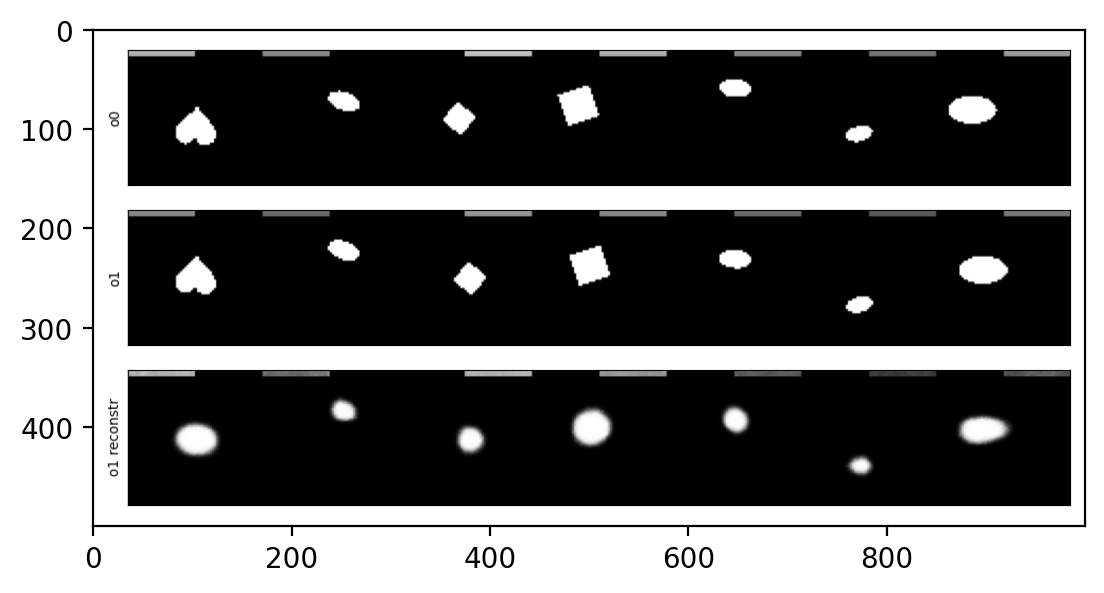

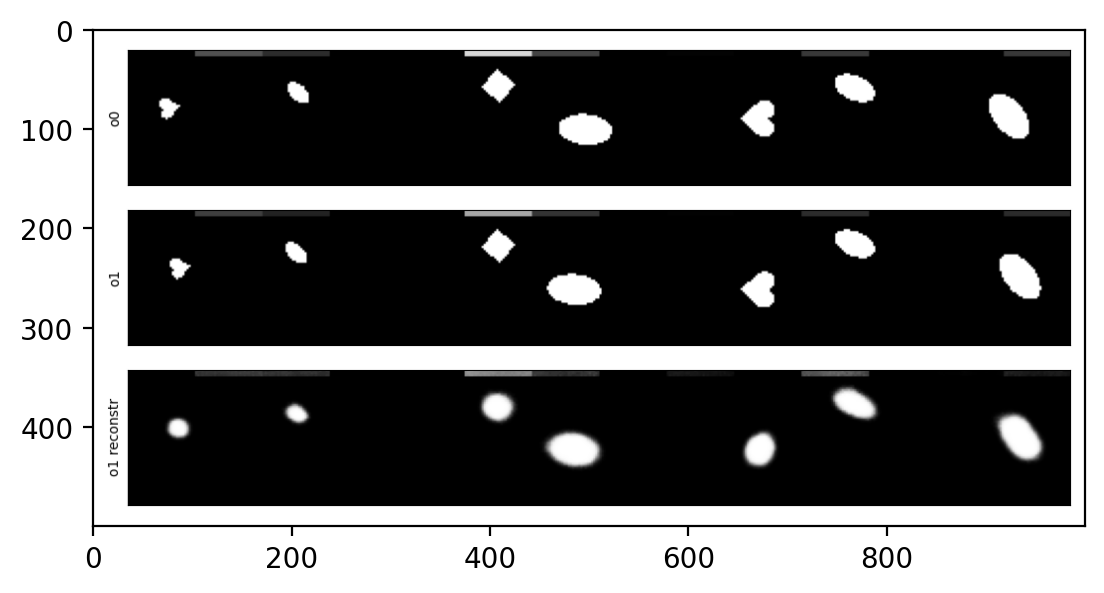

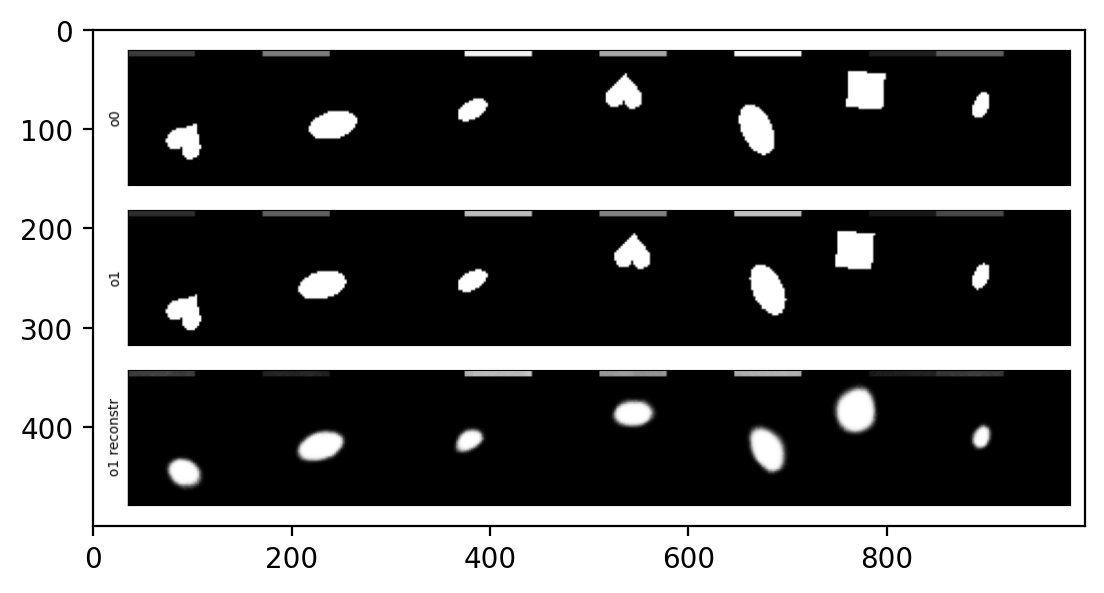

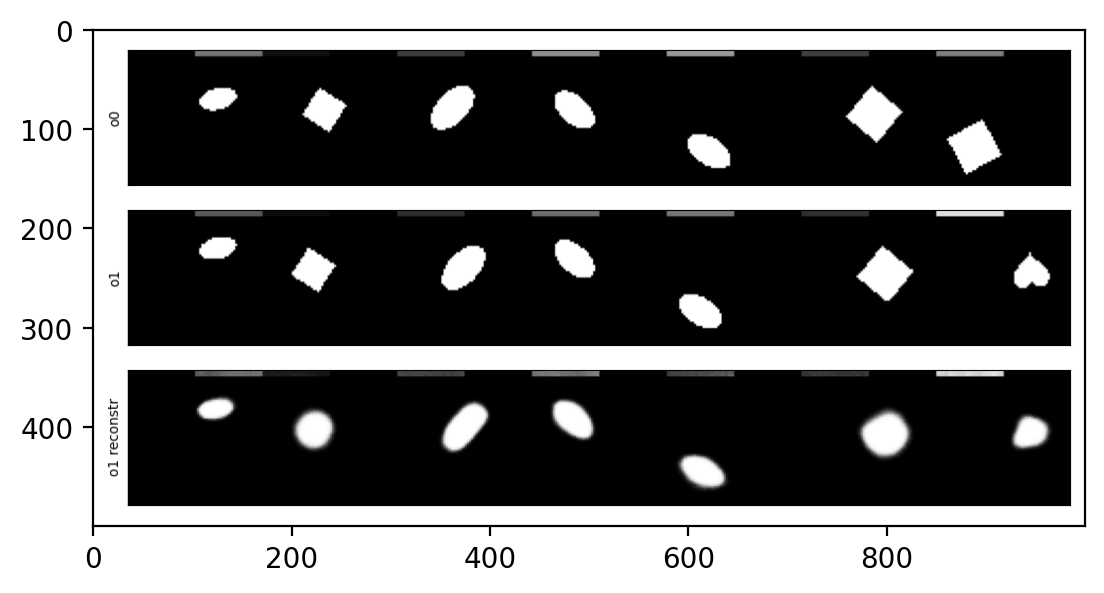

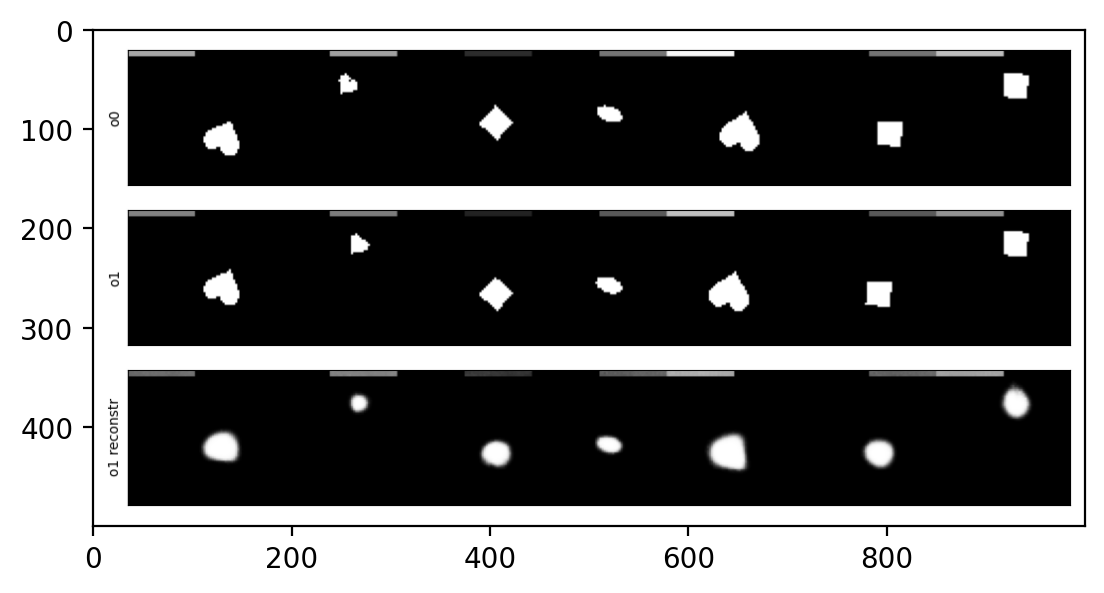

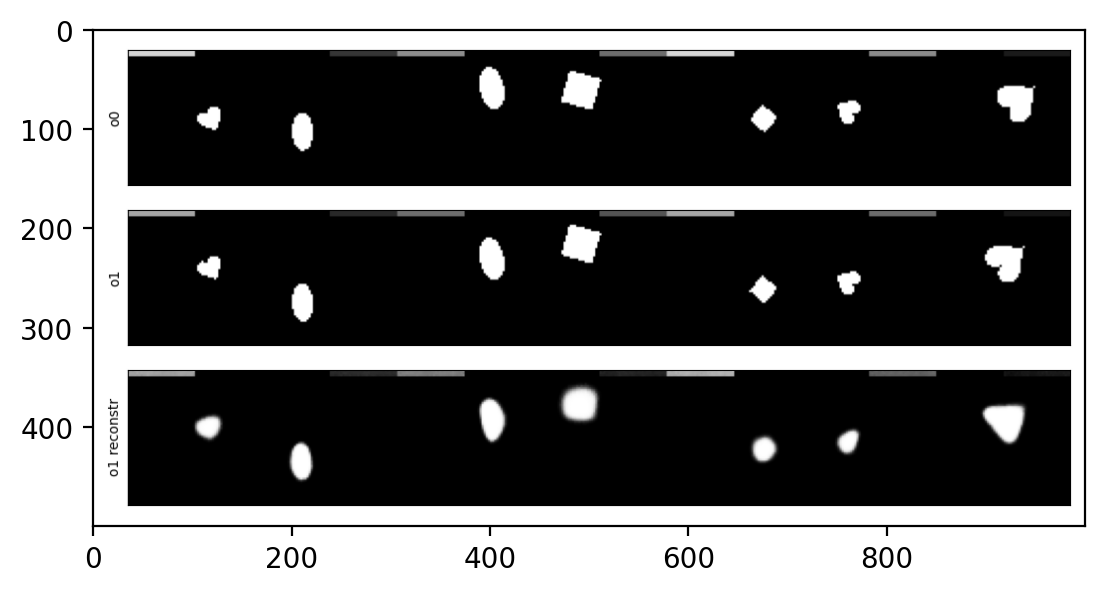

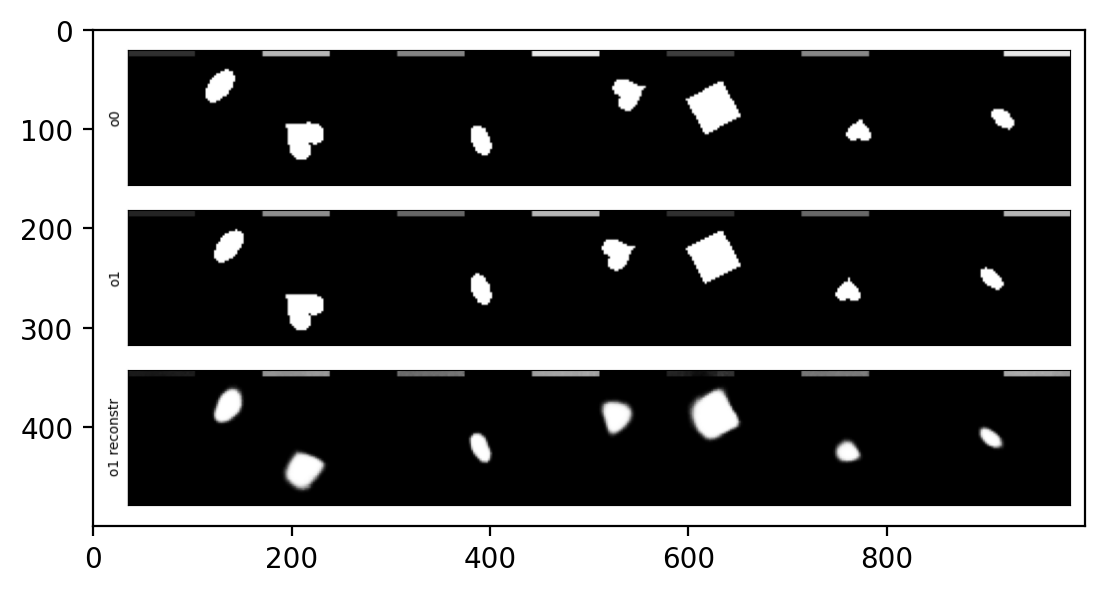

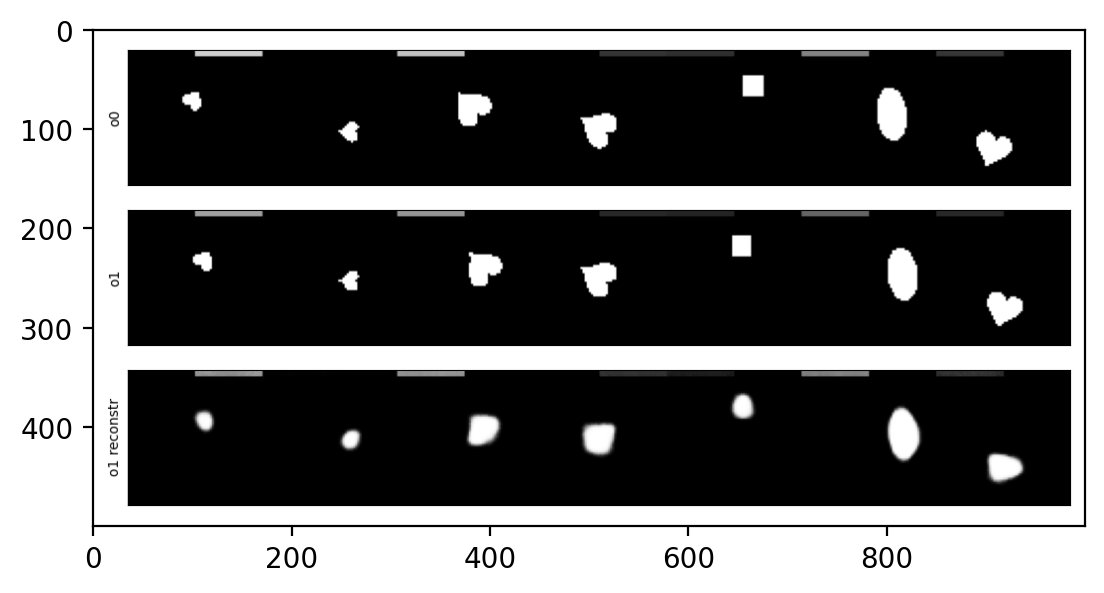

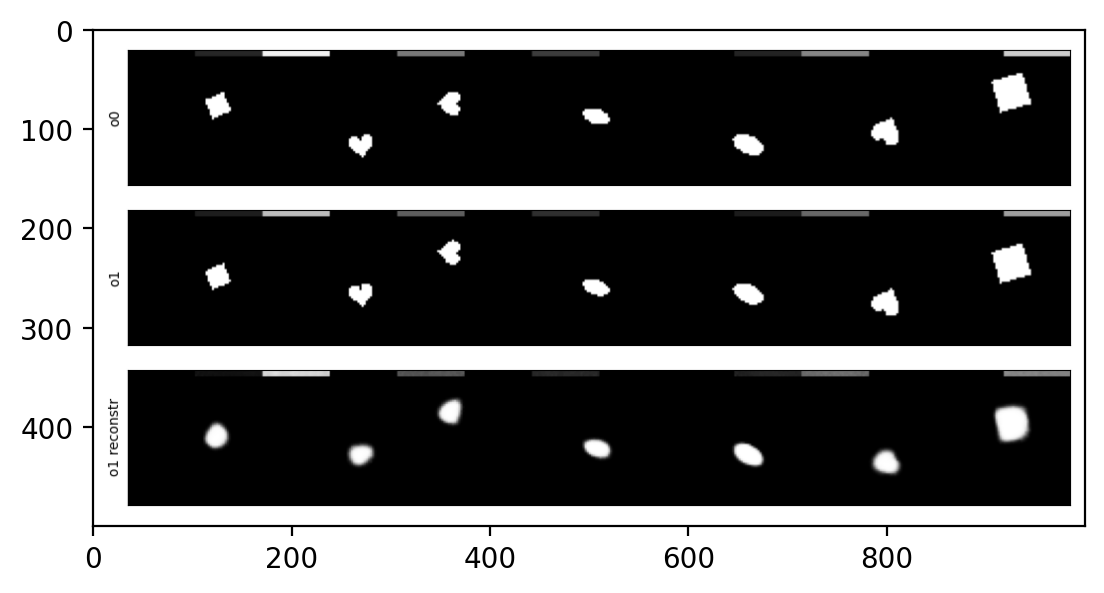

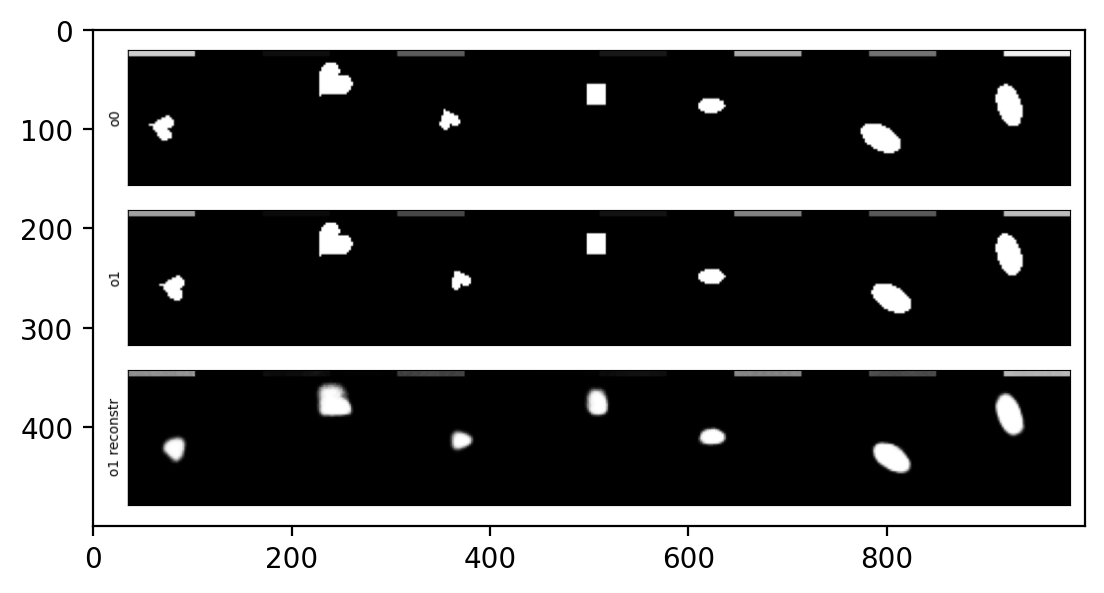

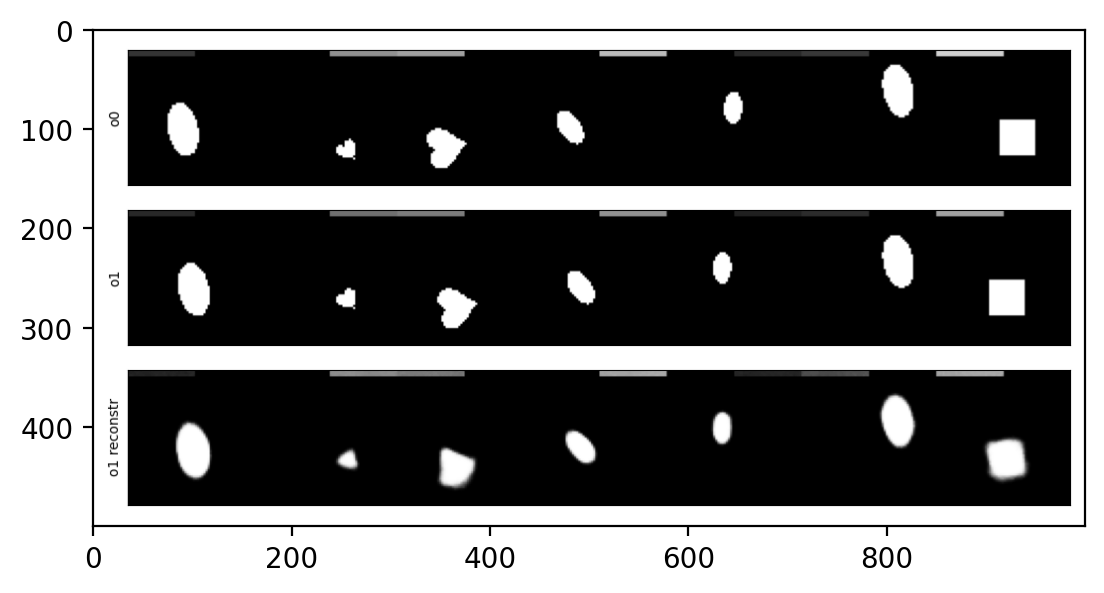

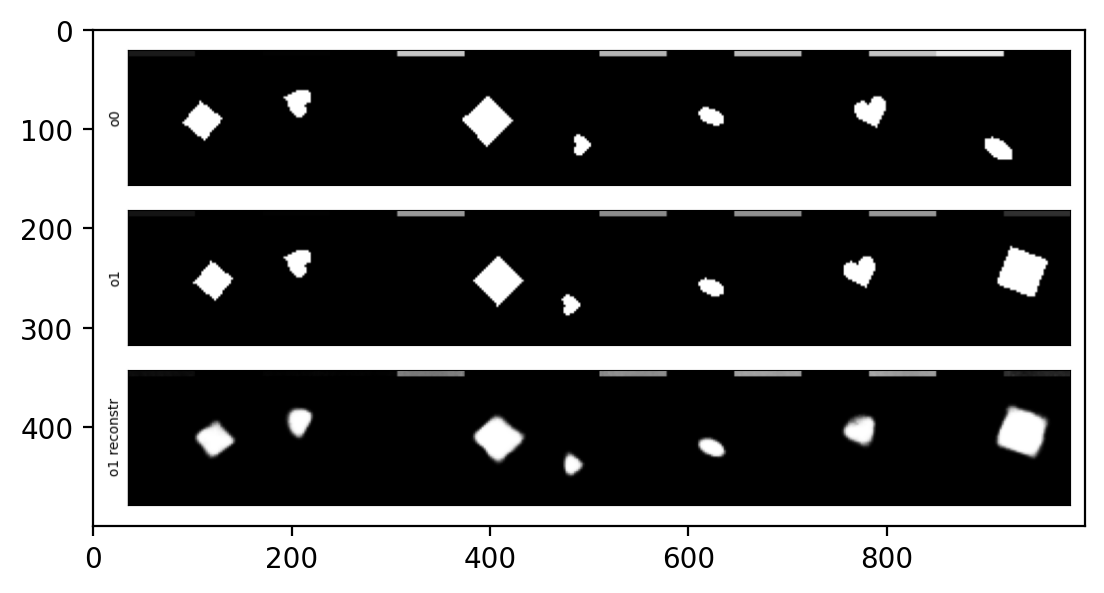

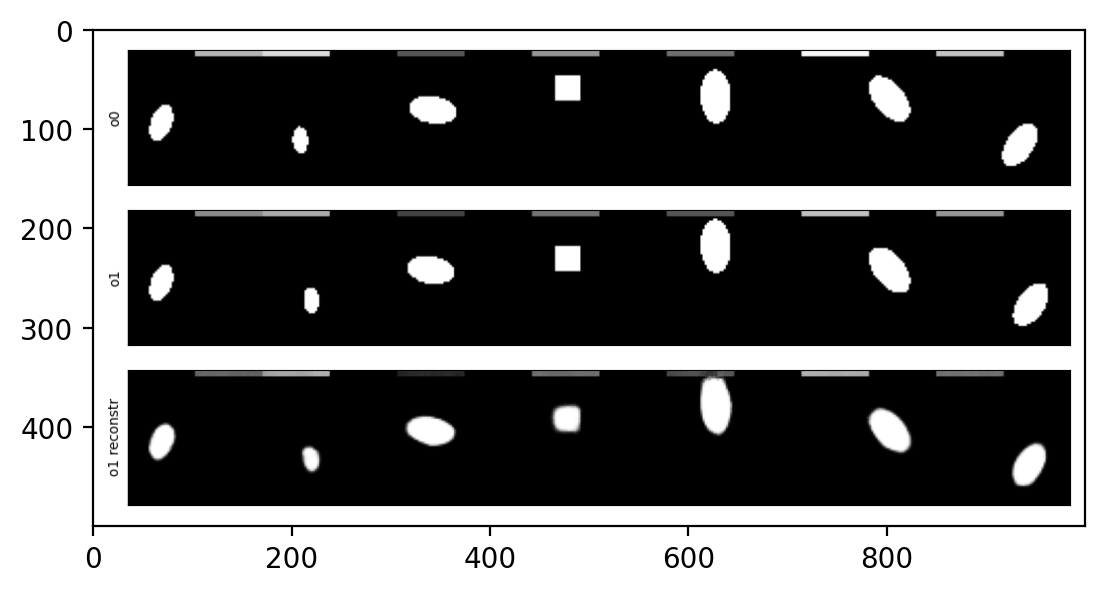

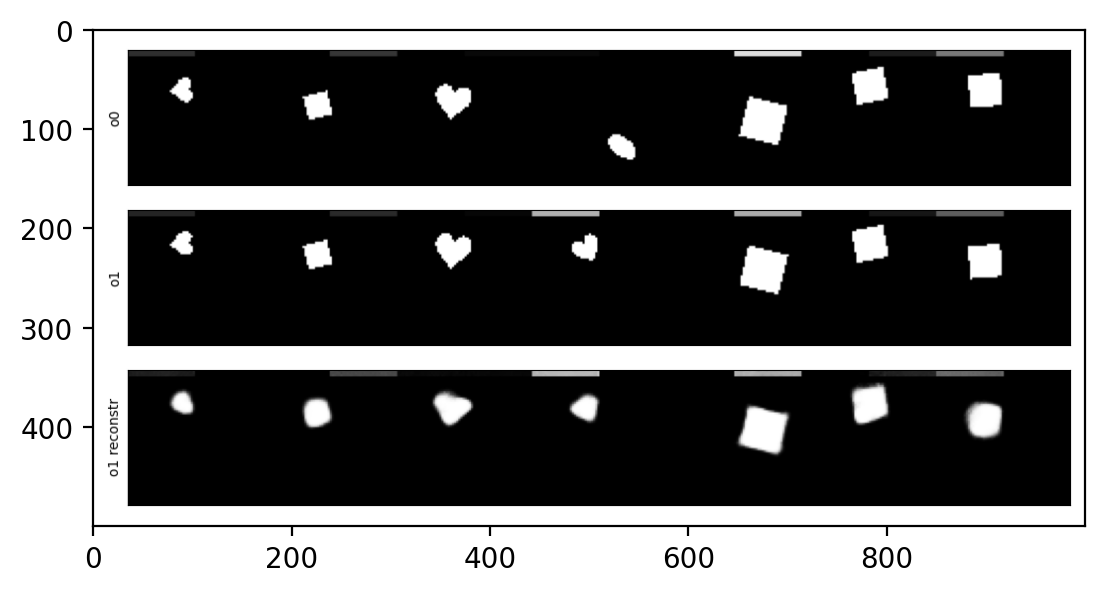

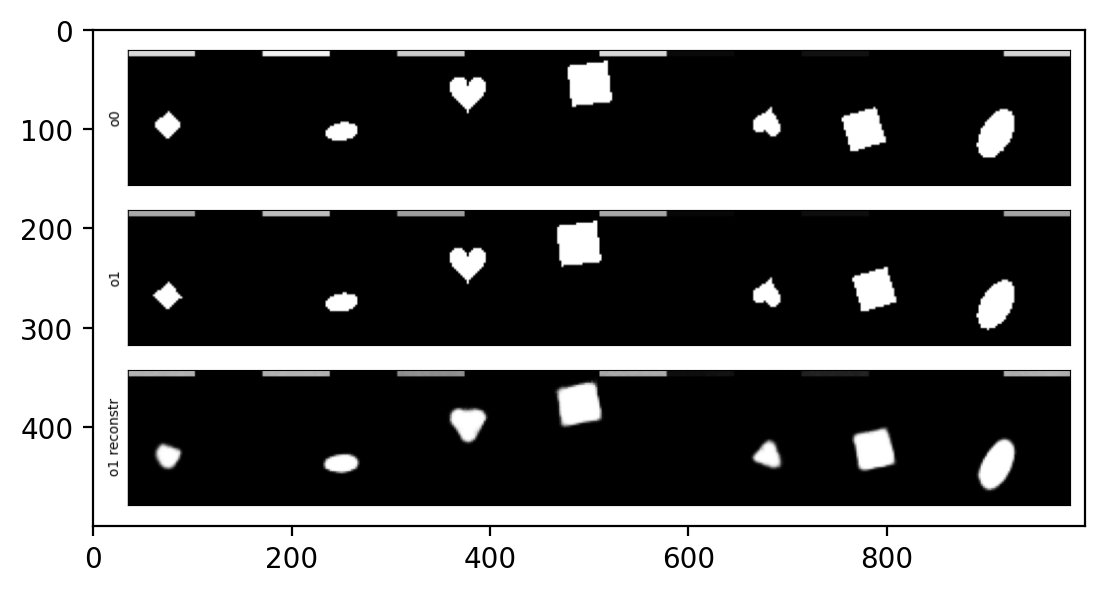

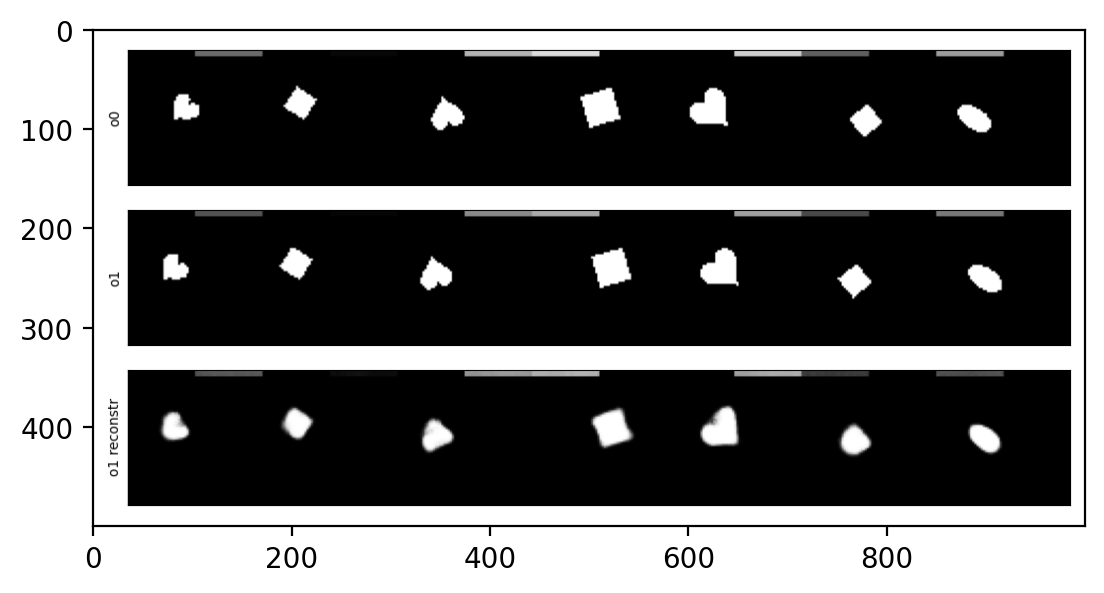

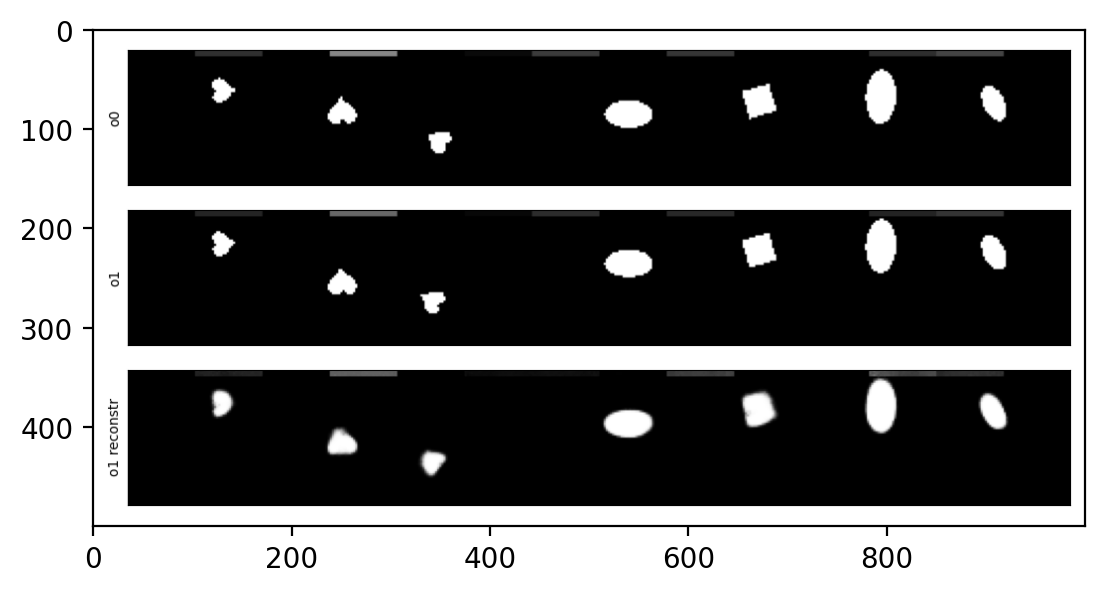

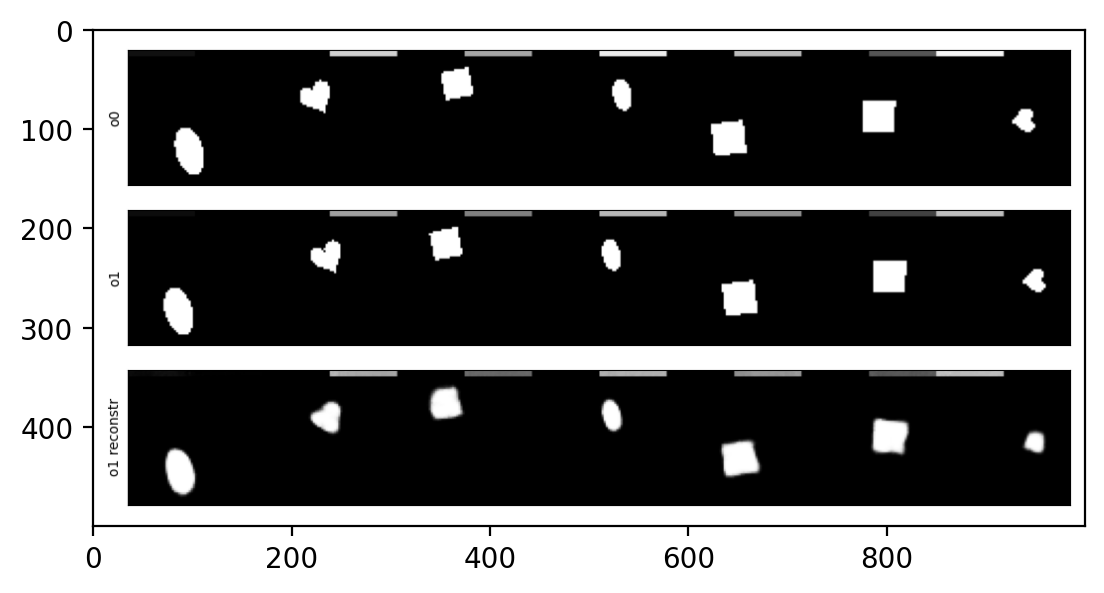

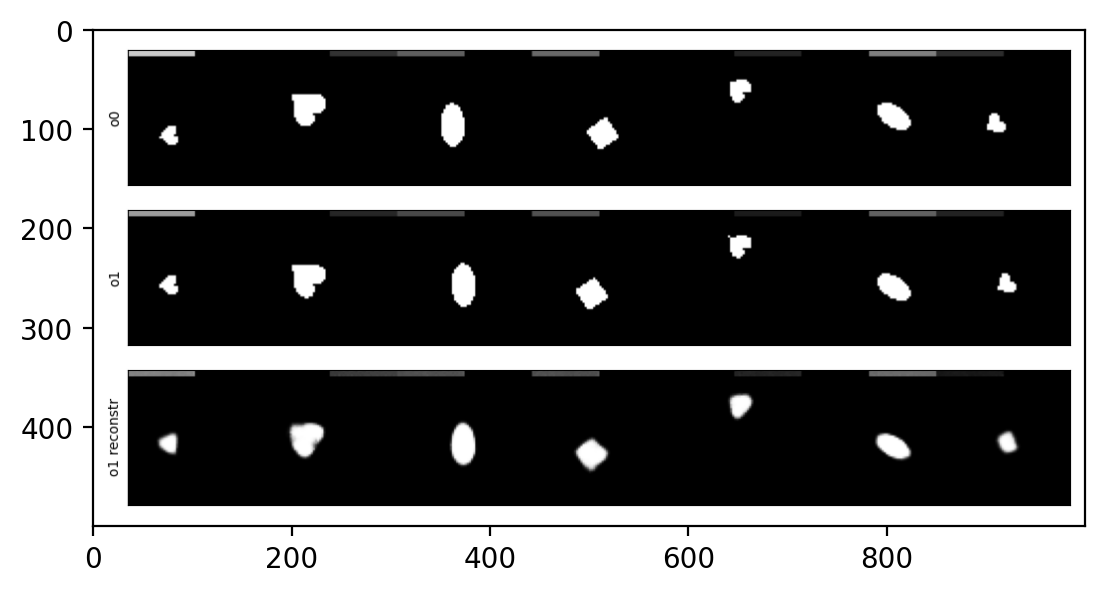

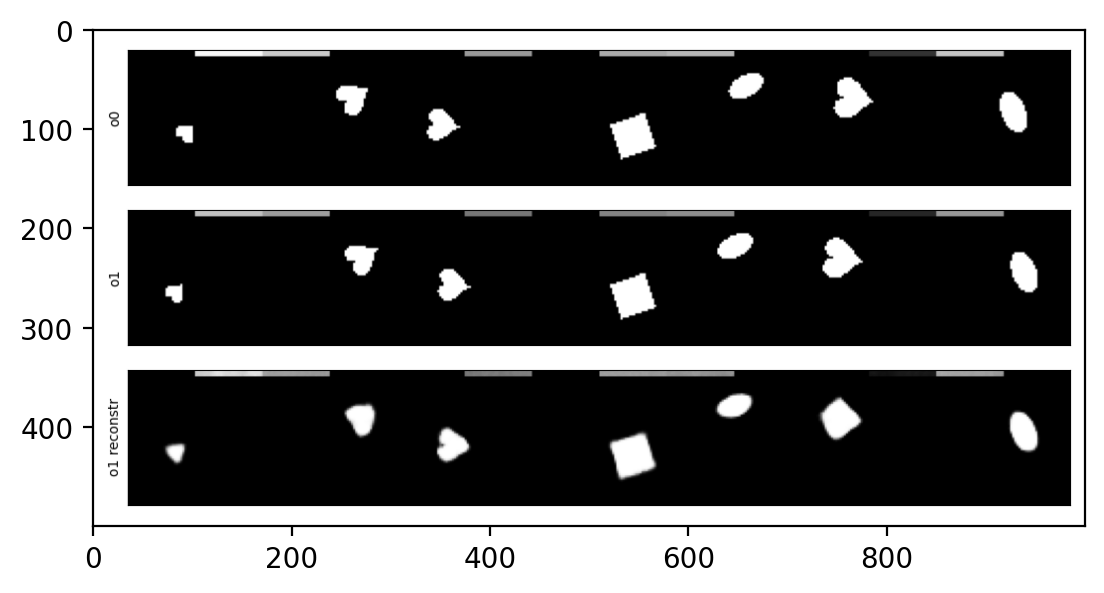

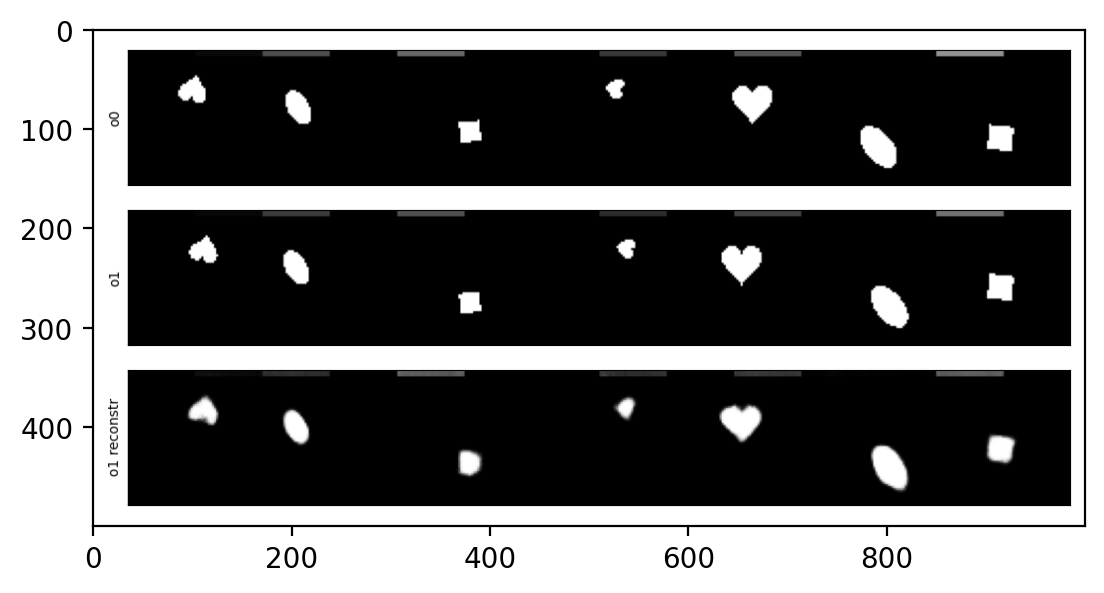

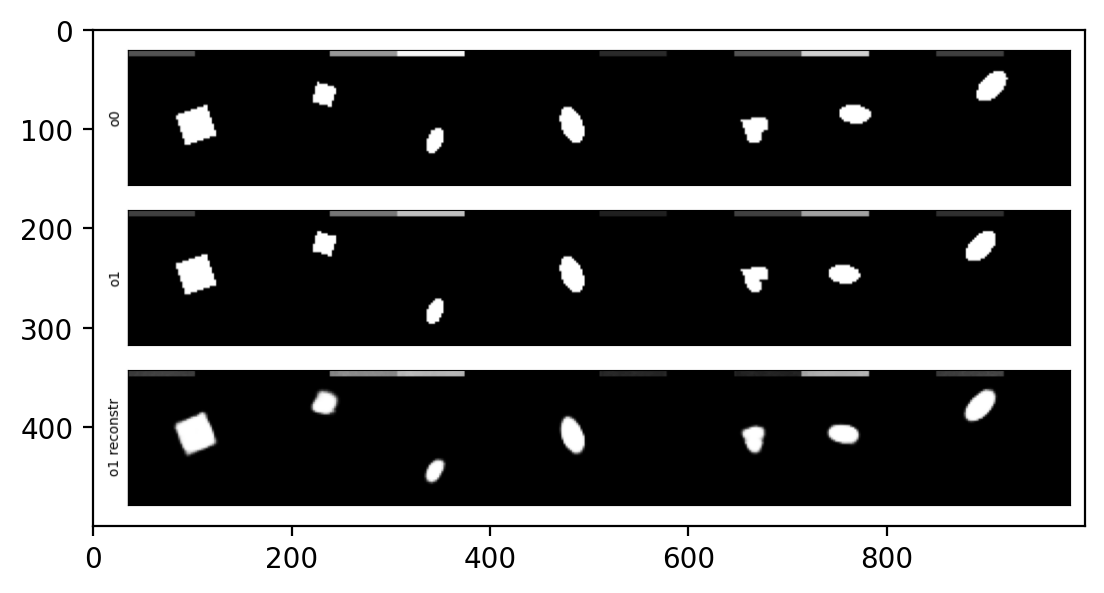

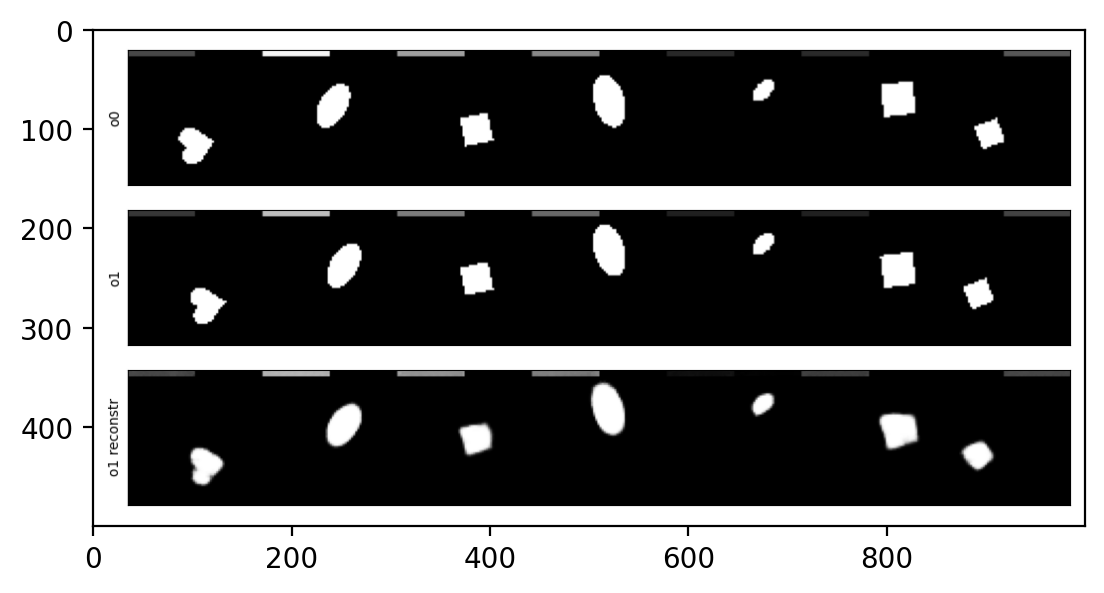

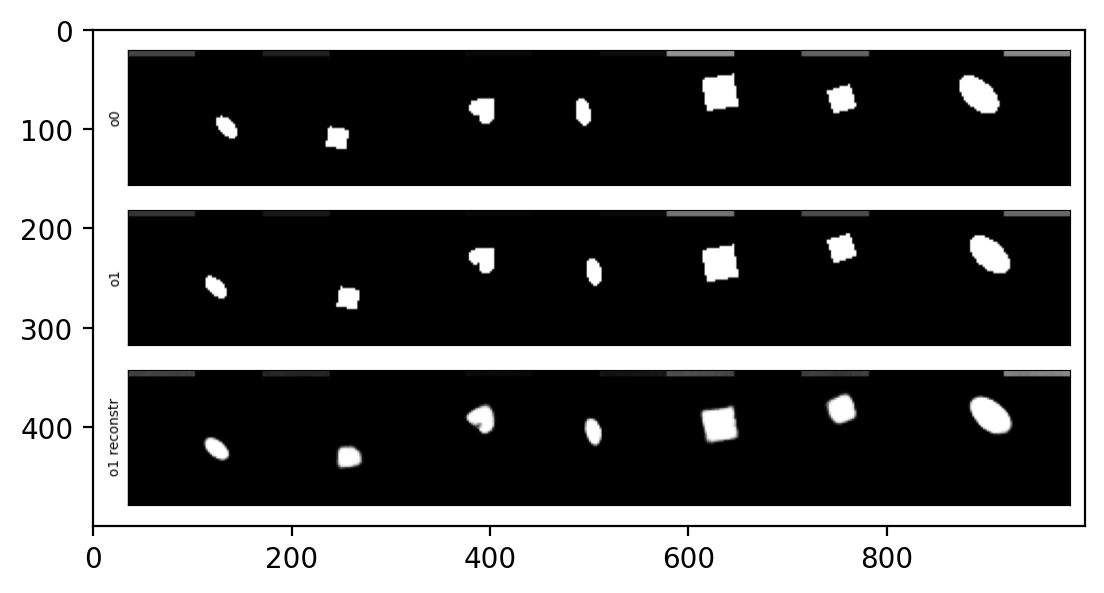

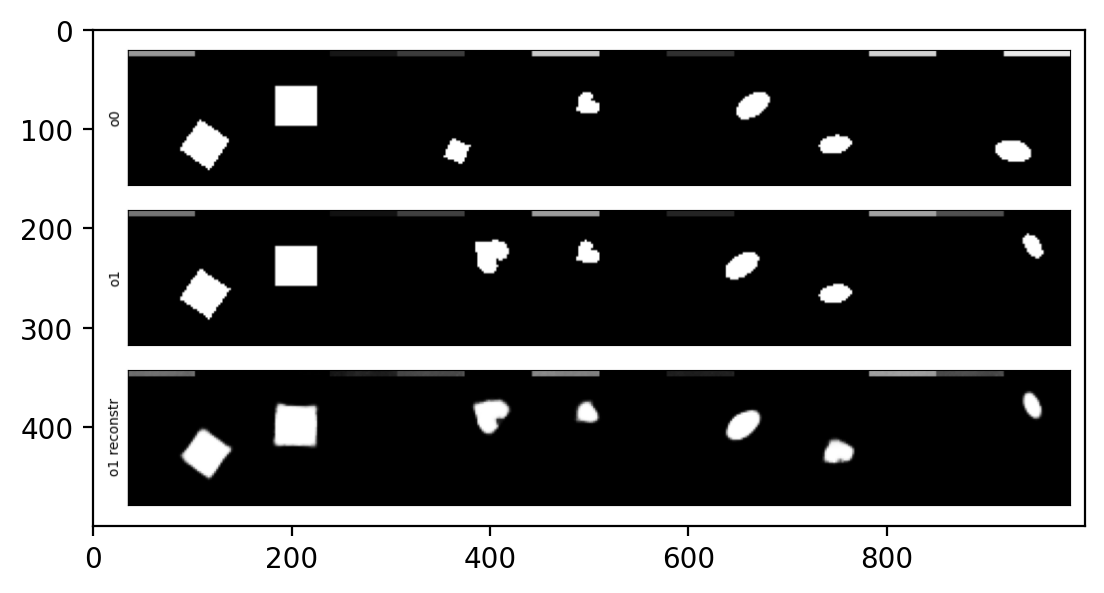

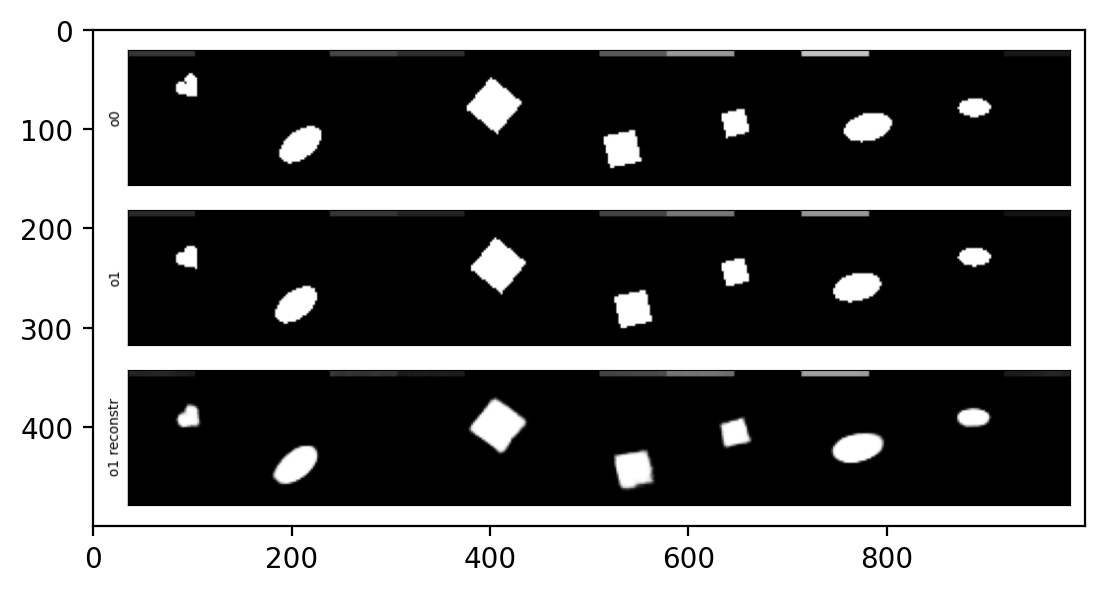

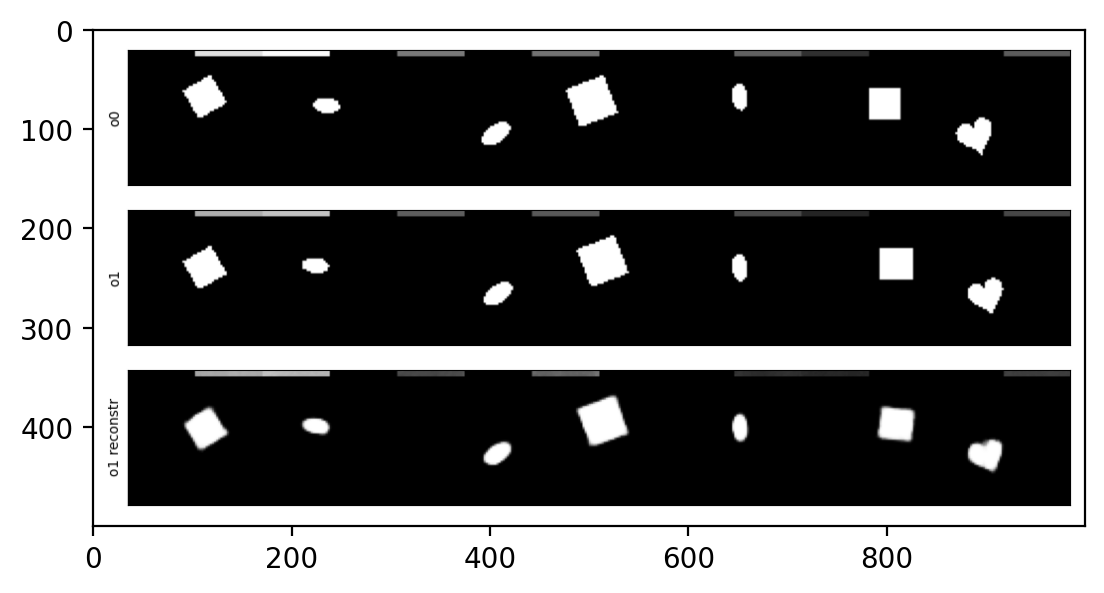

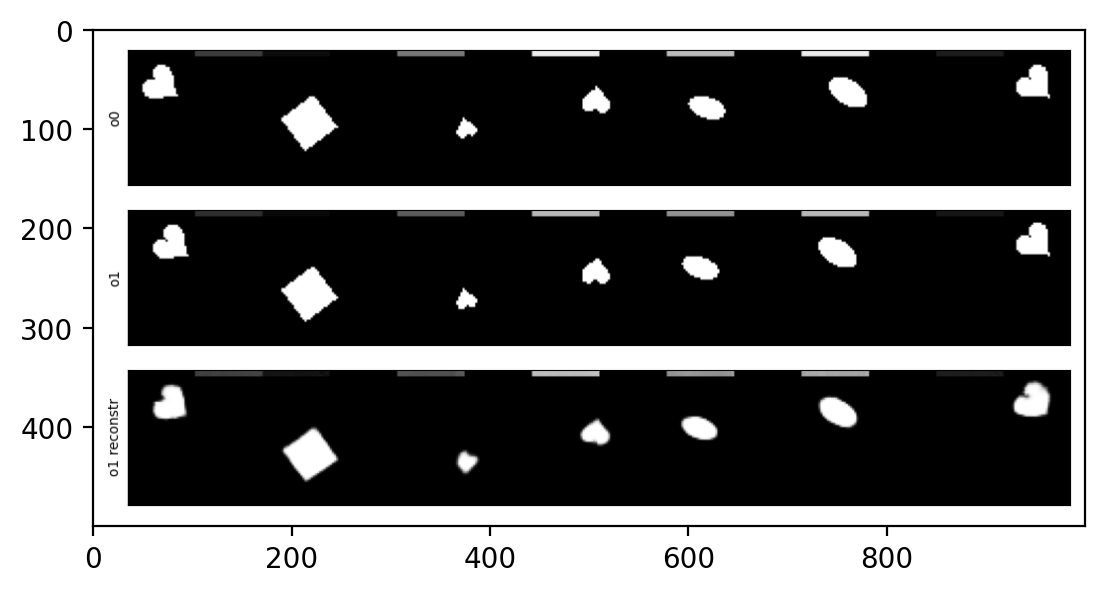

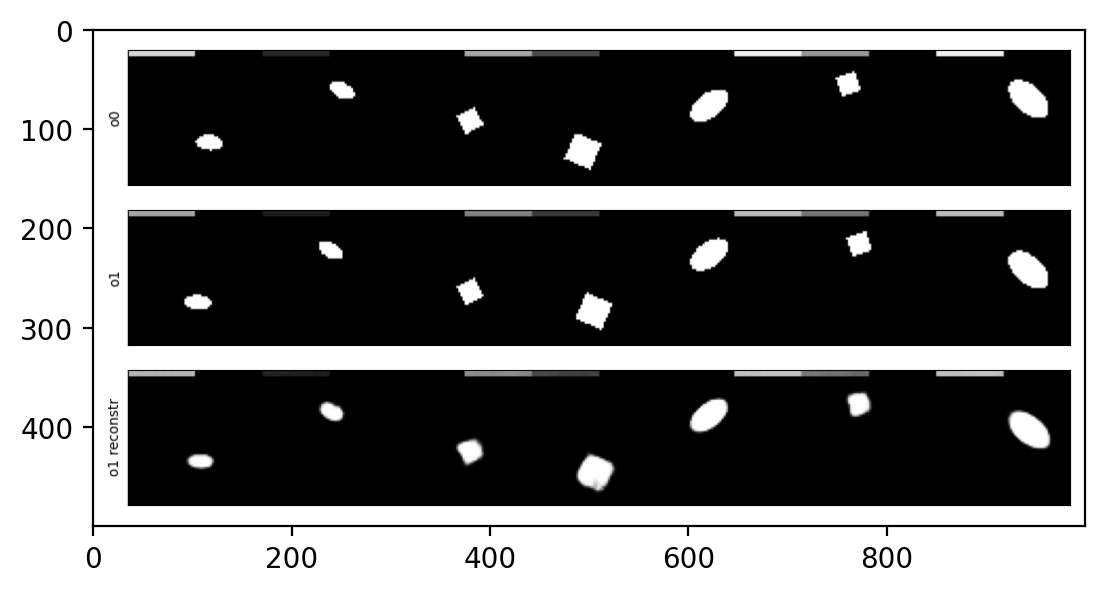

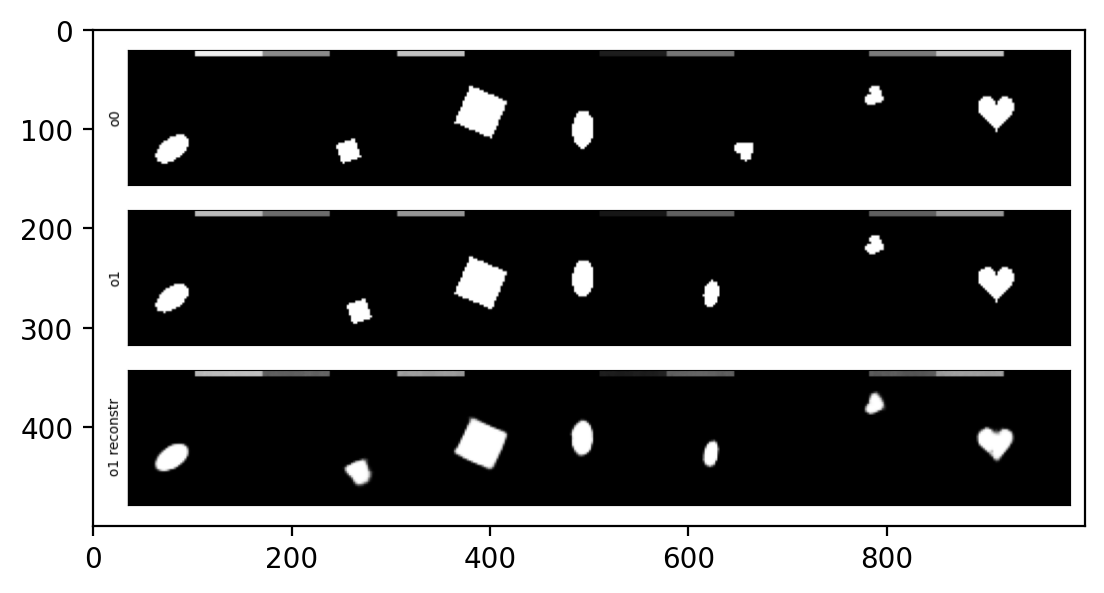

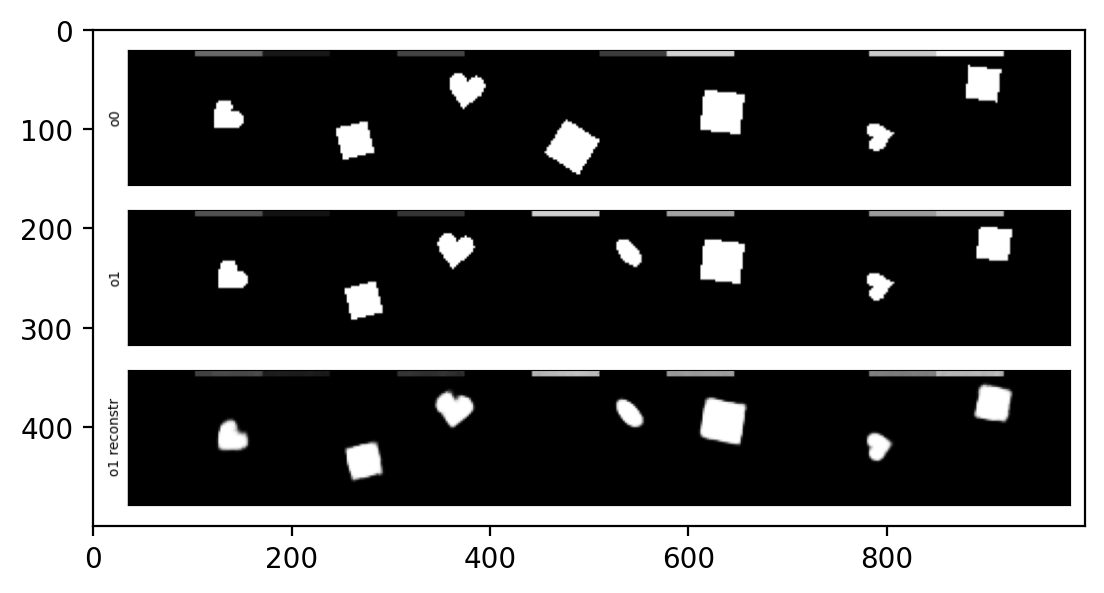

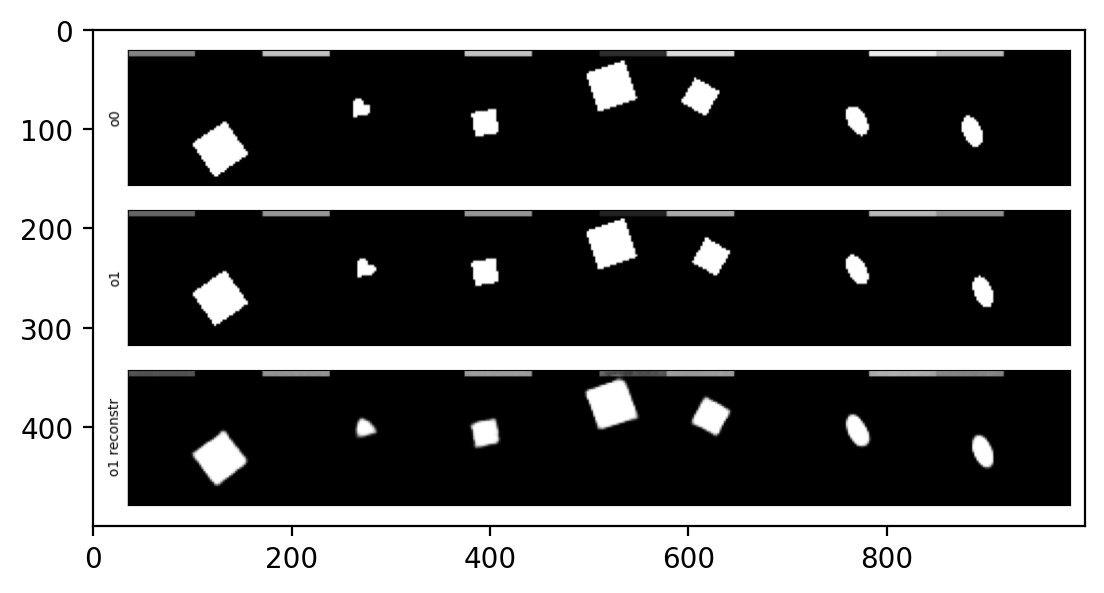

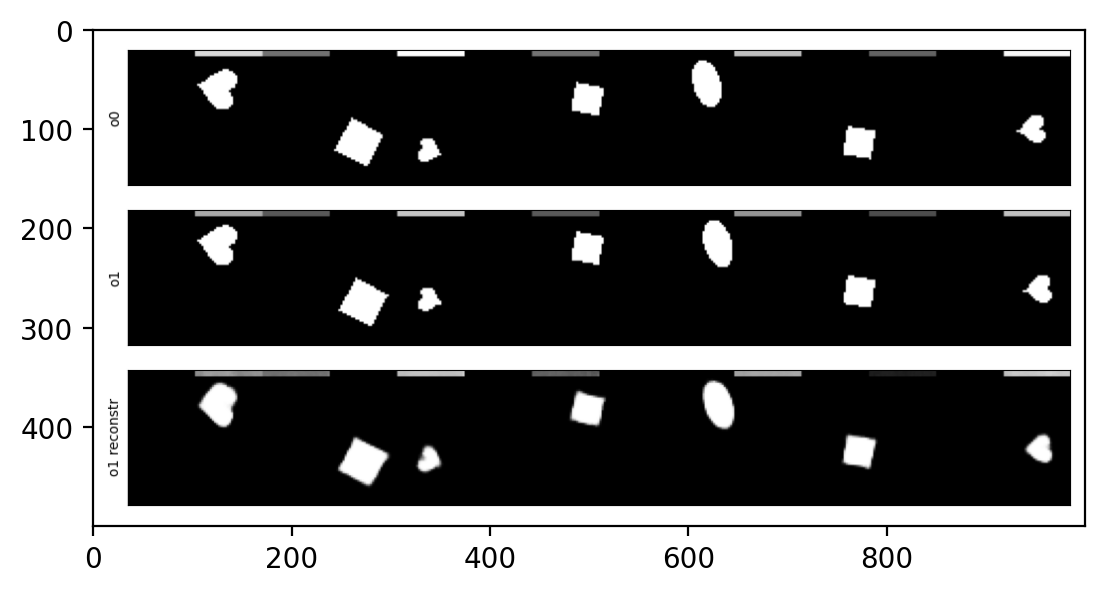

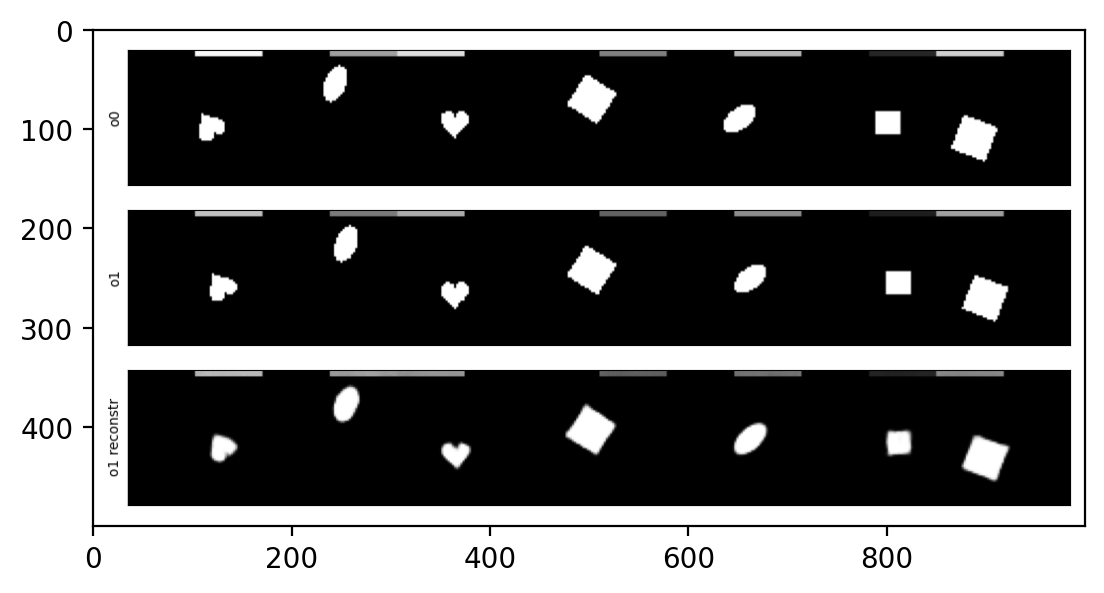

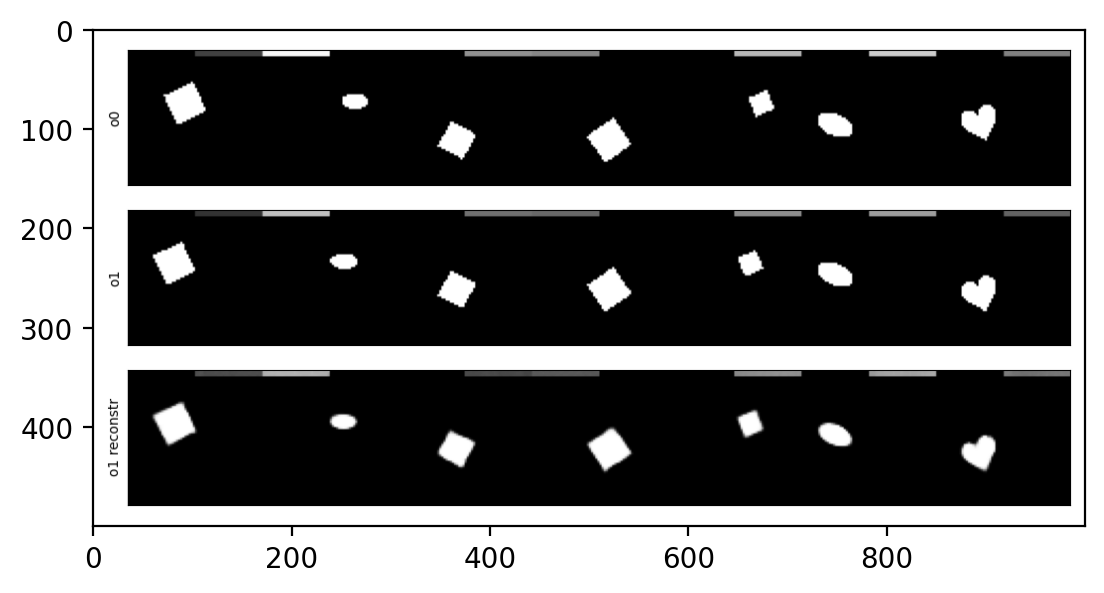

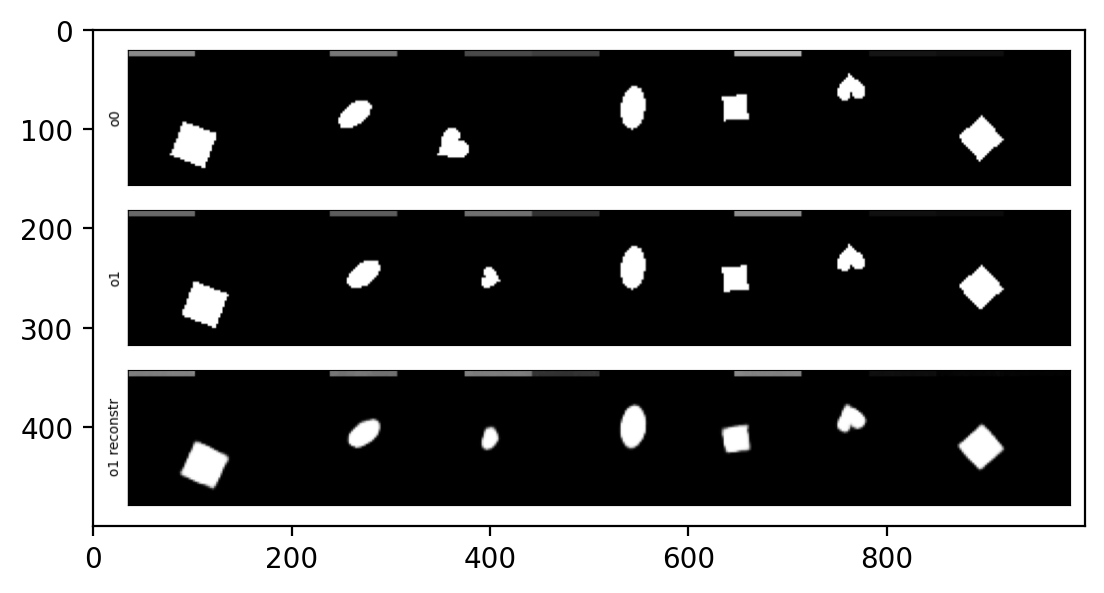

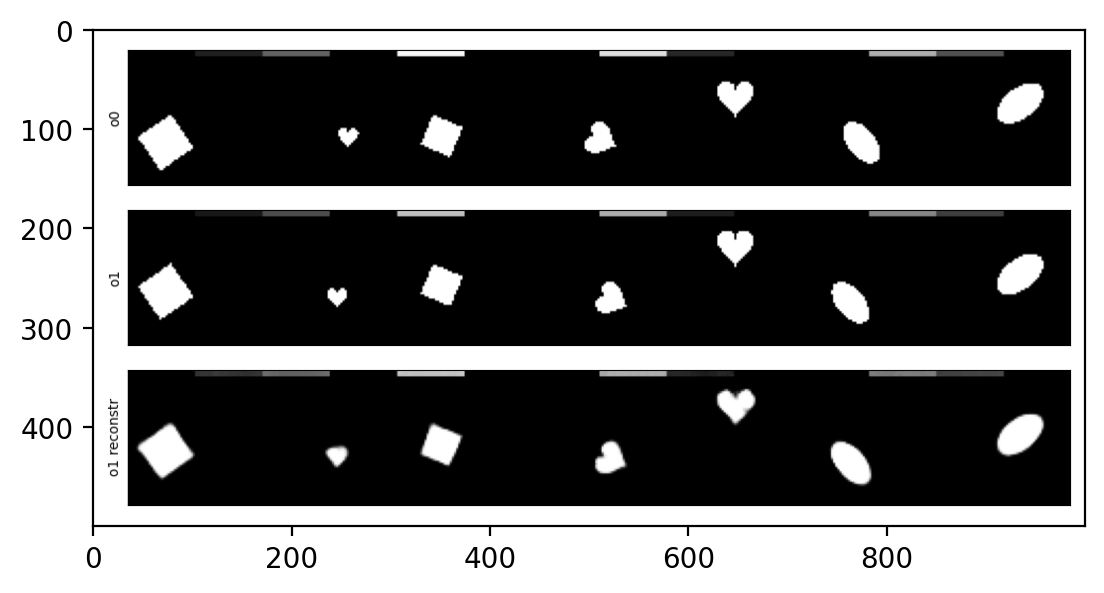

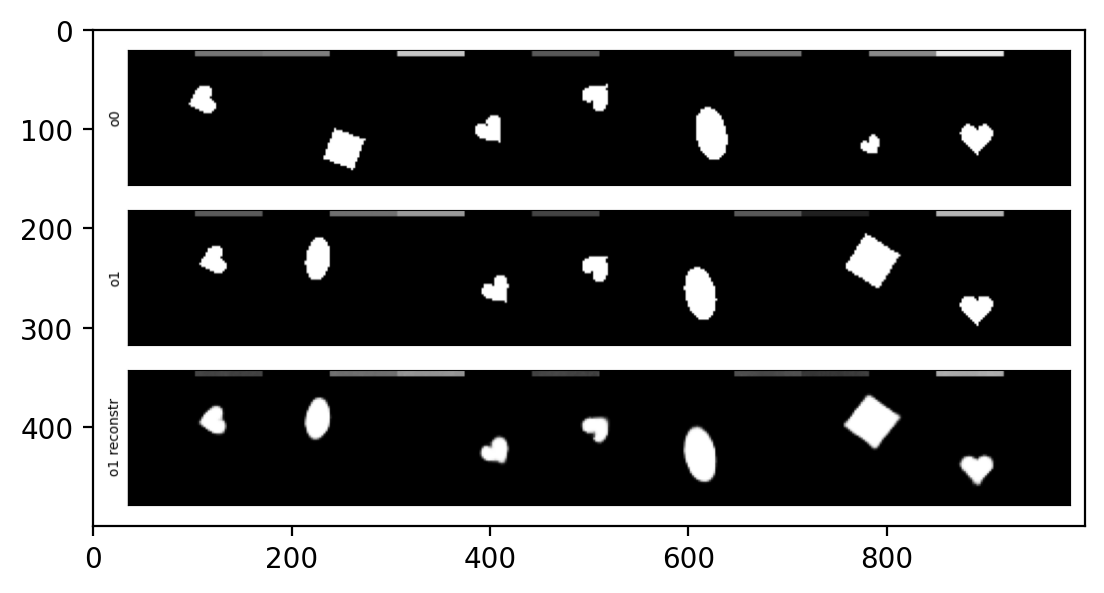

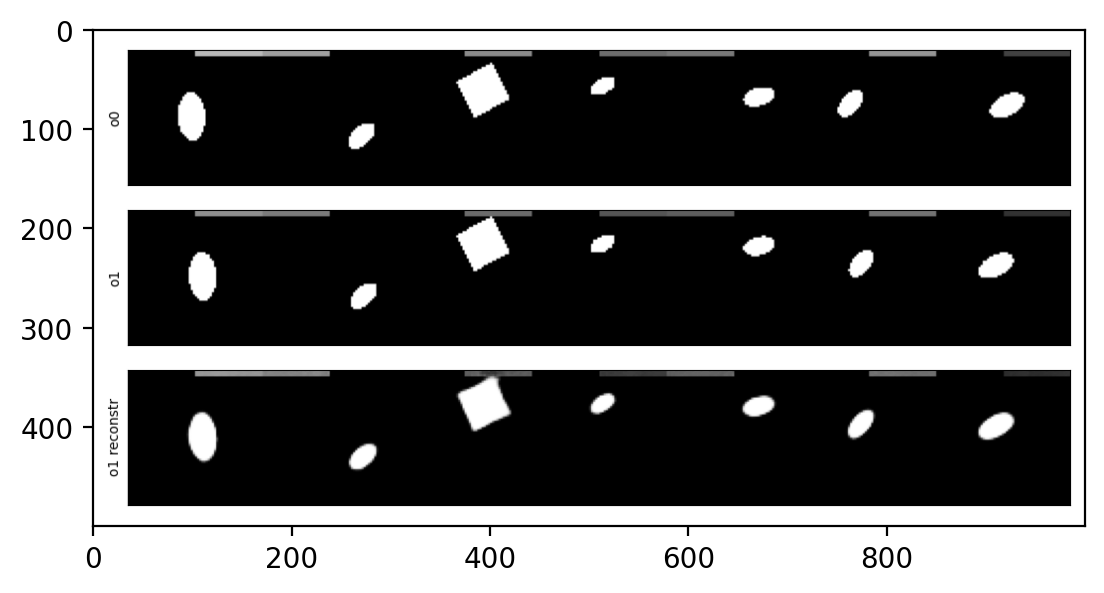

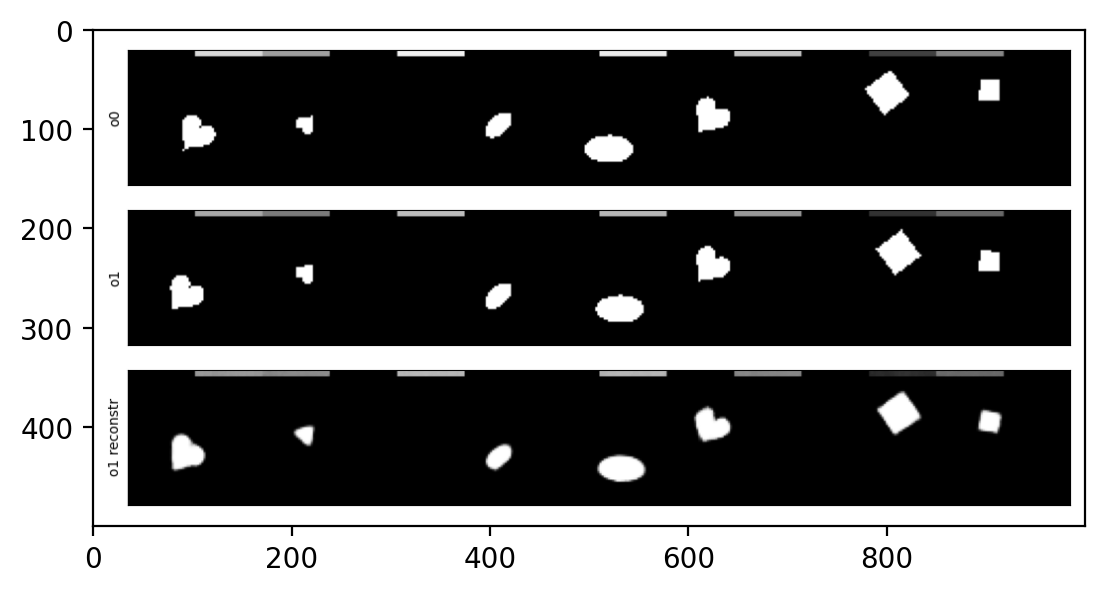

In [29]:
image = np.zeros(shape=[500, 1000, 4,41])
for i in range(1,41):
  image[:,:,:,i] = plt.imread(folder+'/imagination_'+signature+'_'+str(i)+'.png')
  plt.figure(dpi=200)
  plt.imshow( image[:,:,:,i] );


### Tuning curves

---



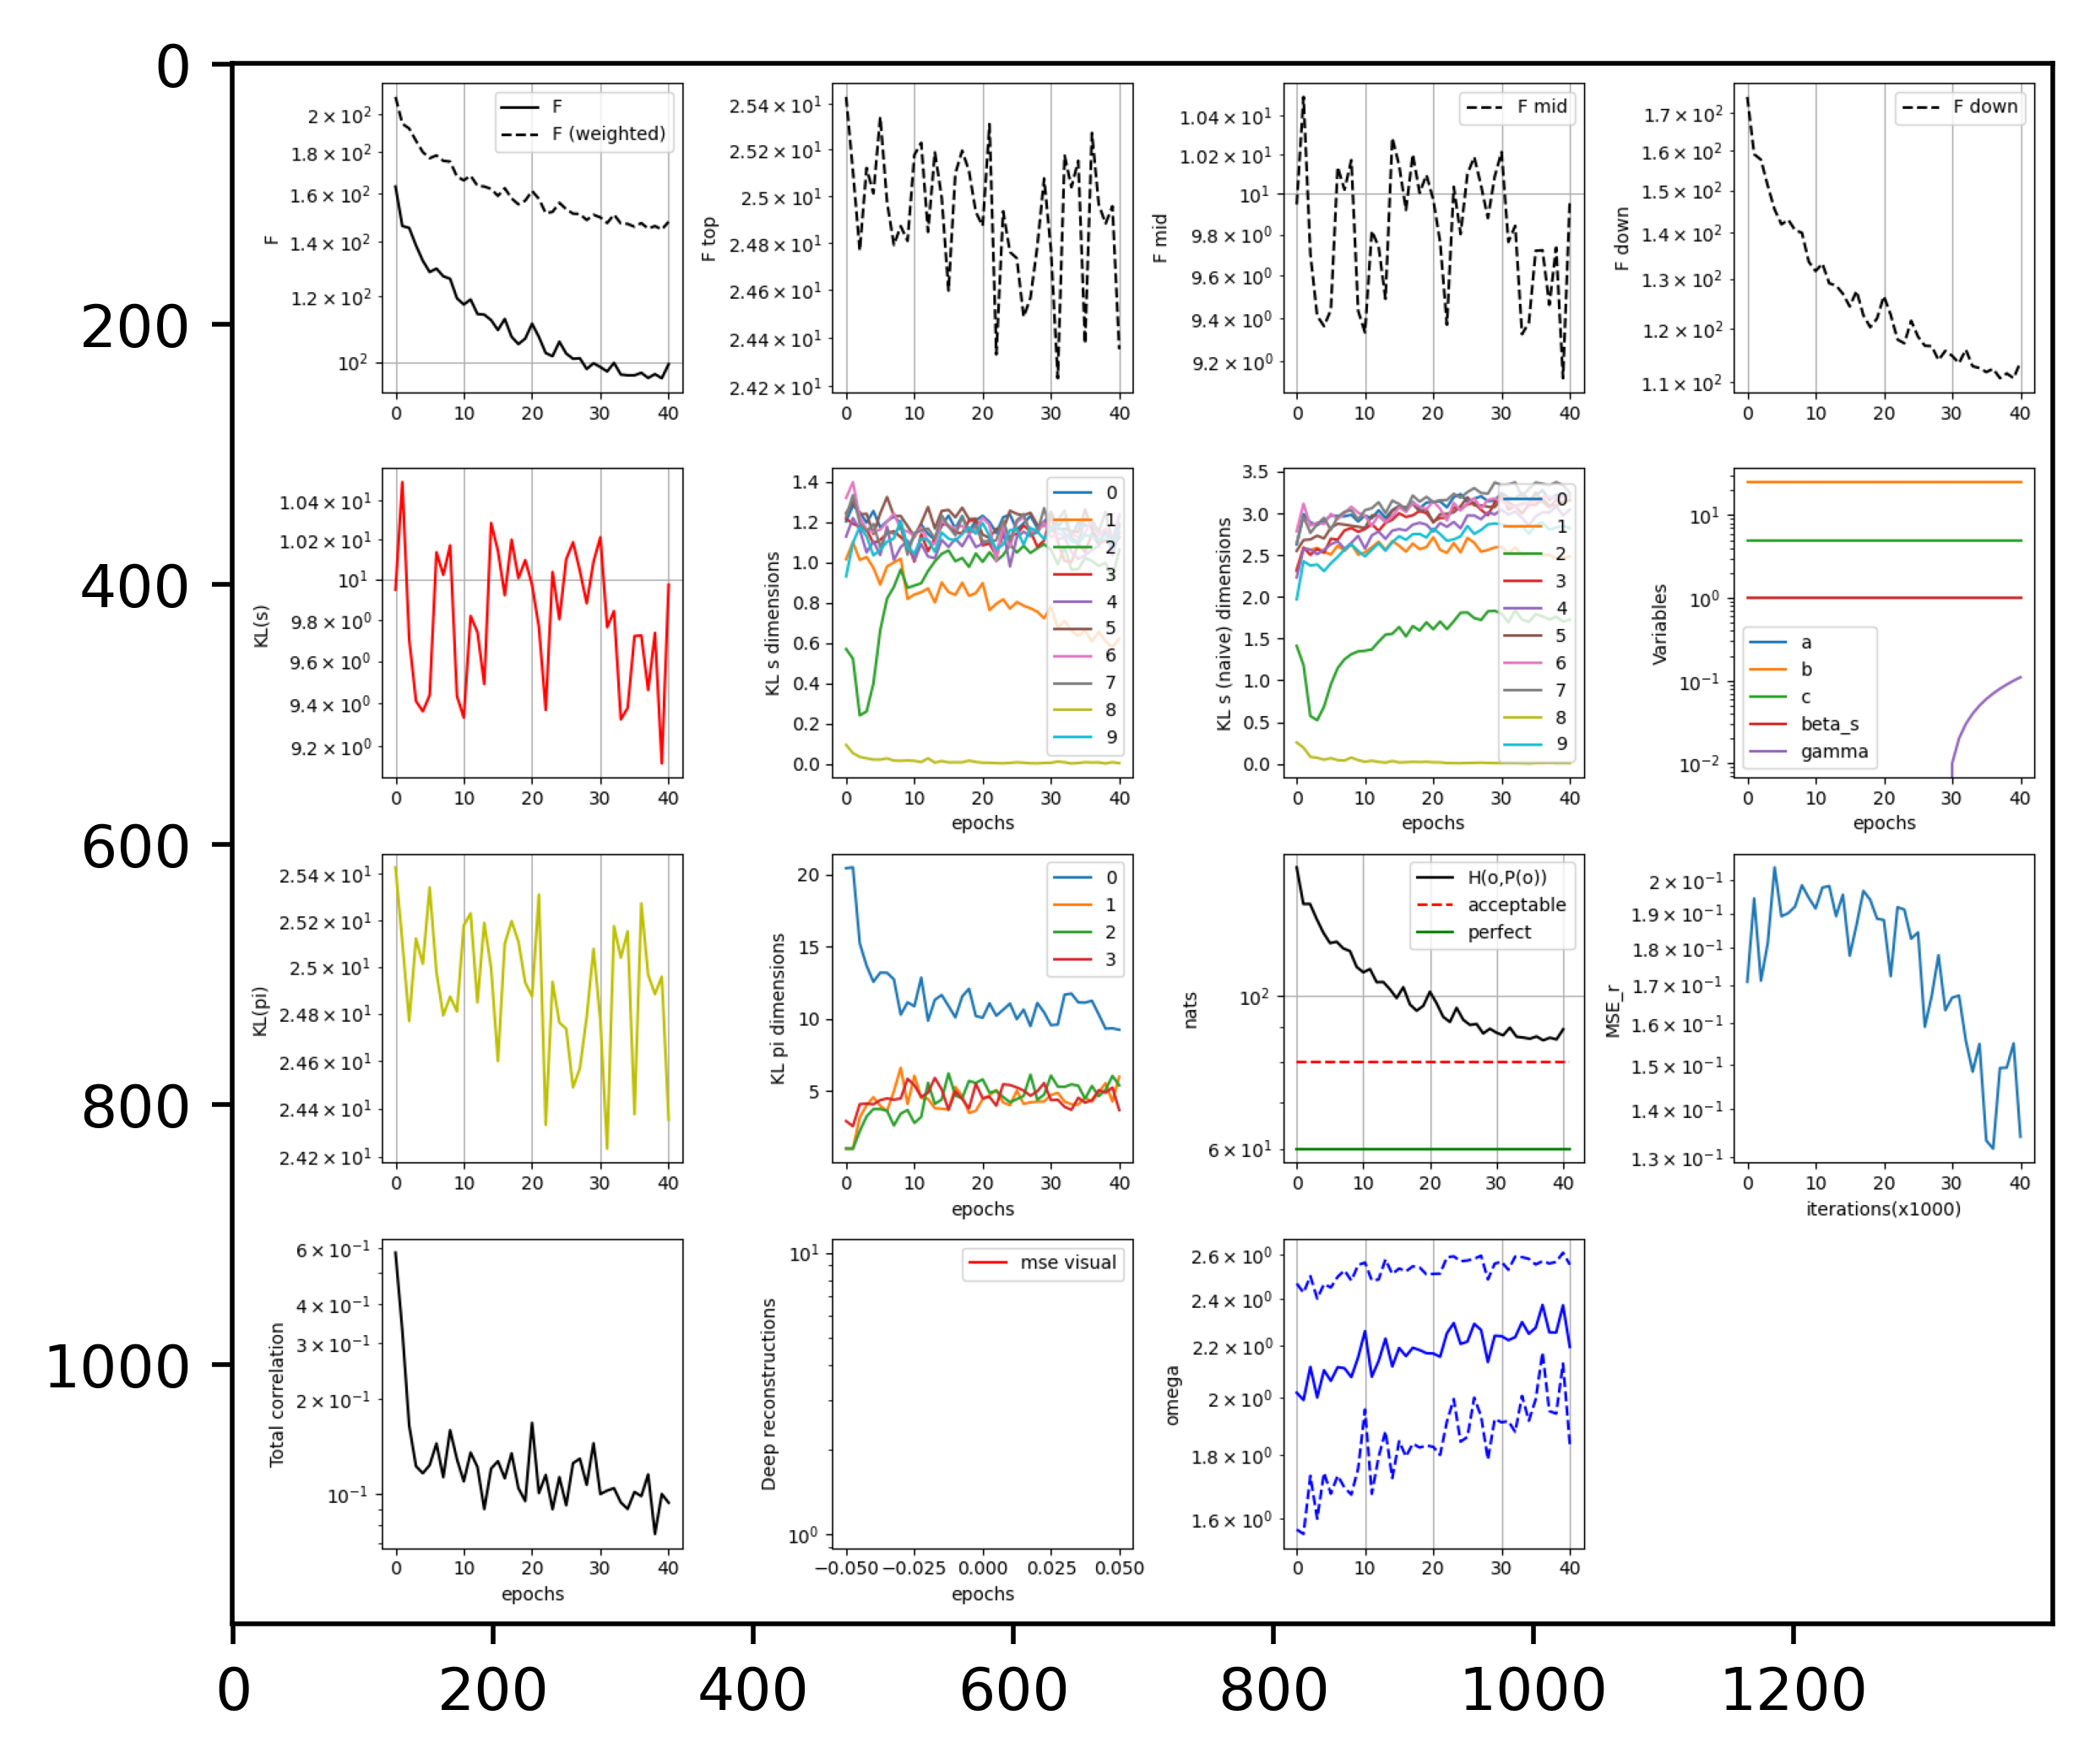

In [30]:
image = plt.imread(folder+'/1_result_'+signature + '.png')
plt.figure(dpi=500)
plt.imshow(image);


### Traversals post learning

---



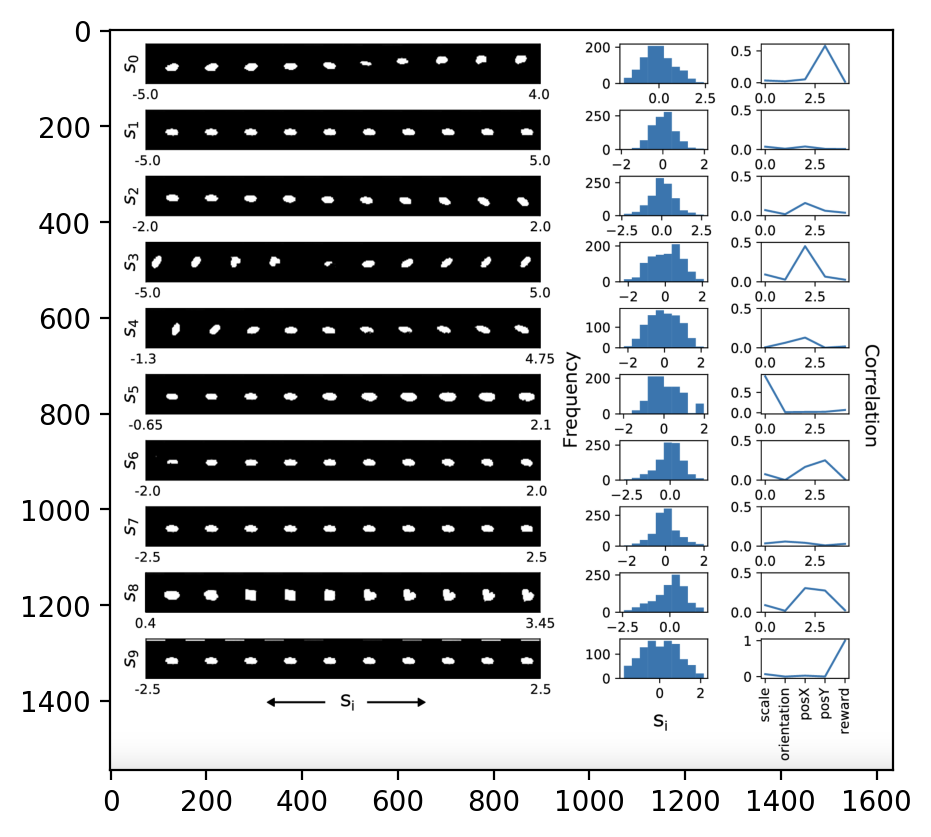

In [31]:
image = plt.imread(folder+'/final_traversals.png')
plt.figure(dpi=200)
plt.imshow(image);